# **ADSP 32023** Computer Vision Final Project

Eugene Kim, Nick Pandolfi, Robin Lee, Sajan Mehta

In [ ]:
import kagglehub
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from pathlib import Path
import cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from scipy import stats

## Dataset

In [ ]:
path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/140k-real-and-fake-faces


In [ ]:
#!ls /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake

In [ ]:
# DATA_DIR   = Path("/root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2/real_vs_fake/real-vs-fake")
DATA_DIR   = Path(path+"/real_vs_fake/real-vs-fake")
IMG_SIZE   = (160, 160)
BATCH_SIZE = 32
EPOCHS     = 30
SEED       = 42
USE_FP16   = True

In [ ]:
def load_split(split: str, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        DATA_DIR / split,
        labels="inferred",
        label_mode="binary",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=SEED,
        validation_split=None,
        class_names=["real", "fake"]
    )
    total_images = len(ds) * BATCH_SIZE
    print(f"{split} dataset: {len(ds)} batches, {total_images} images")
    return ds

train_ds = load_split("train")
val_ds   = load_split("valid")
test_ds  = load_split("test", shuffle=False)

AUTOTUNE  = tf.data.AUTOTUNE
train_ds  = train_ds.cache().shuffle(1024).prefetch(AUTOTUNE)
val_ds    = val_ds.prefetch(AUTOTUNE)
test_ds   = test_ds.prefetch(AUTOTUNE)

# Print total images across all splits
total_train = len(train_ds) * BATCH_SIZE
total_valid = len(val_ds) * BATCH_SIZE
total_test = len(test_ds) * BATCH_SIZE
total_all = total_train + total_valid + total_test

print("\nTotal images:")
print(f"Train: {total_train:,}")
print(f"Valid: {total_valid:,}")
print(f"Test:  {total_test:,}")
print(f"Total: {total_all:,}")

Found 100000 files belonging to 2 classes.
train dataset: 3125 batches, 100000 images
Found 20000 files belonging to 2 classes.
valid dataset: 625 batches, 20000 images
Found 20000 files belonging to 2 classes.
test dataset: 625 batches, 20000 images

Total images:
Train: 100,000
Valid: 20,000
Test:  20,000
Total: 140,000


## Exploratory Data Analysis

Summarize Data: record counts, missing values, and schema

In [ ]:
print(f"\nDataset Splits:")
print(f"├── Train: {total_train:,} images ({total_train/total_all*100:.1f}%)")
print(f"├── Valid: {total_valid:,} images ({total_valid/total_all*100:.1f}%)")
print(f"└── Test:  {total_test:,} images ({total_test/total_all*100:.1f}%)")
print(f"Total: {total_all:,} images")


Dataset Splits:
├── Train: 100,000 images (71.4%)
├── Valid: 20,000 images (14.3%)
└── Test:  20,000 images (14.3%)
Total: 140,000 images


In [ ]:
print(f"\nDirectory Structure Analysis:")
for split in ['train', 'valid', 'test']:
    split_path = DATA_DIR / split
    real_path = split_path / 'real'
    fake_path = split_path / 'fake'
    real_count = len(list(real_path.glob('*.jpg'))) if real_path.exists() else 0
    fake_count = len(list(fake_path.glob('*.jpg'))) if fake_path.exists() else 0
    print(f"{split.capitalize()} Split:")
    print(f"  ├── Real images: {real_count:,}")
    print(f"  └── Fake images: {fake_count:,}")
    print(f"  Balance ratio: {real_count/(real_count+fake_count)*100:.1f}% real, {fake_count/(real_count+fake_count)*100:.1f}% fake")


Directory Structure Analysis:
Train Split:
  ├── Real images: 50,000
  └── Fake images: 50,000
  Balance ratio: 50.0% real, 50.0% fake
Valid Split:
  ├── Real images: 10,000
  └── Fake images: 10,000
  Balance ratio: 50.0% real, 50.0% fake
Test Split:
  ├── Real images: 10,000
  └── Fake images: 10,000
  Balance ratio: 50.0% real, 50.0% fake


In [ ]:
def analyze_dataset_distribution(datasets, names):
    distributions = {}
    for ds, name in zip(datasets, names):
        labels = []
        total_batches = 0
        for batch_images, batch_labels in ds:
            labels.extend(batch_labels.numpy())
            total_batches += 1
        labels = np.array(labels)
        real_count = np.sum(labels == 0)
        fake_count = np.sum(labels == 1)
        distributions[name] = {
            'real': int(real_count),
            'fake': int(fake_count),
            'total': len(labels),
            'real_pct': real_count / len(labels) * 100,
            'fake_pct': fake_count / len(labels) * 100
        }
        print(f"  {name} - Real: {real_count}, Fake: {fake_count}")
    return distributions

In [ ]:
distributions = analyze_dataset_distribution(
    [train_ds, val_ds, test_ds],
    ['Train', 'Validation', 'Test']
)

  Train - Real: 50000, Fake: 50000
  Validation - Real: 10000, Fake: 10000
  Test - Real: 10000, Fake: 10000


Visualize the raw dataset using charts and tables (line/bar charts, q-q plots, heatmaps, violin, etc.)

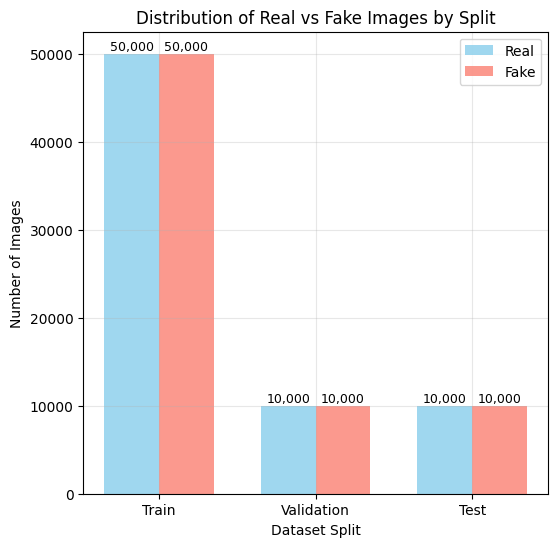

In [ ]:
plt.figure(figsize=(6, 6))
splits = list(distributions.keys())
real_counts = [distributions[split]['real'] for split in splits]
fake_counts = [distributions[split]['fake'] for split in splits]

x = np.arange(len(splits))
width = 0.35

bars1 = plt.bar(x - width/2, real_counts, width, label='Real', color='skyblue', alpha=0.8)
bars2 = plt.bar(x + width/2, fake_counts, width, label='Fake', color='salmon', alpha=0.8)

plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.title('Distribution of Real vs Fake Images by Split')
plt.xticks(x,splits)
plt.legend()
plt.grid(True, alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

Text(0.5, 1.0, 'Overall Dataset Composition')

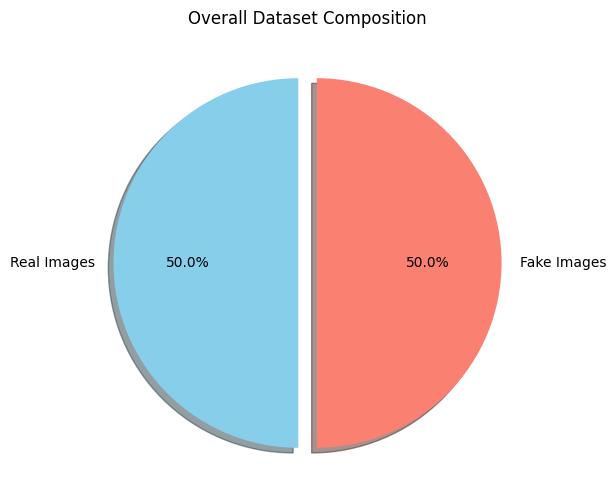

In [ ]:
plt.figure(figsize=(6, 6))
total_real = sum(real_counts)
total_fake = sum(fake_counts)
sizes = [total_real, total_fake]
labels = ['Real Images', 'Fake Images']
colors = ['skyblue', 'salmon']
explode = (0.05, 0.05)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Overall Dataset Composition')

Image Data: Histograms, samples, outliers

In [ ]:
def extract_samples(dataset, num_samples=32):
    images_list = []
    labels_list = []
    for batch_images, batch_labels in dataset.take(1):
        batch_images_np = batch_images.numpy()
        batch_labels_np = batch_labels.numpy()

        n_samples = min(num_samples, len(batch_images_np))
        images_list = batch_images_np[:n_samples]
        labels_list = batch_labels_np[:n_samples]
        break
    return images_list, labels_list

In [ ]:
sample_images, sample_labels = extract_samples(train_ds, 32)

(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

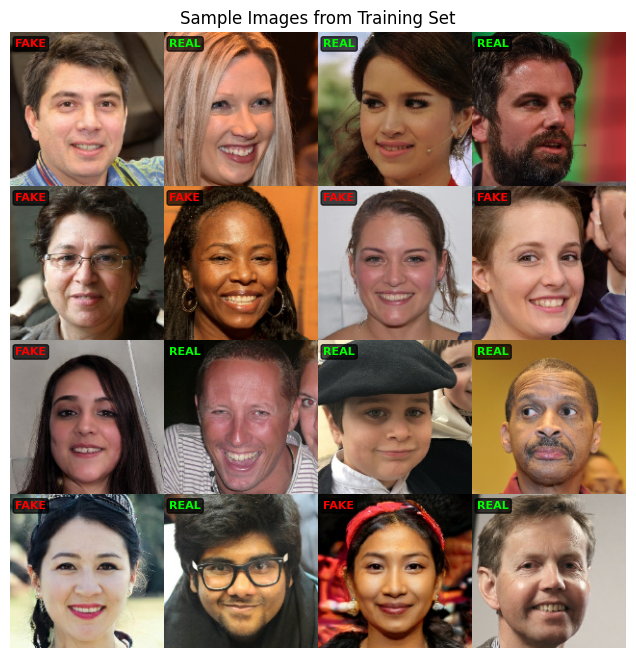

In [ ]:
plt.figure(figsize=(8, 8))
n_samples_display = 16
grid_size = 4
sample_grid = np.zeros((grid_size * IMG_SIZE[0], grid_size * IMG_SIZE[1], 3))

label_positions = []
label_texts = []

for i in range(min(n_samples_display, len(sample_images))):
    row = i // grid_size
    col = i % grid_size
    img = sample_images[i]
    label = sample_labels[i]

    if img.max() > 1.0:
        img = img / 255.0
    start_row = row * IMG_SIZE[0]
    end_row = start_row + IMG_SIZE[0]
    start_col = col * IMG_SIZE[1]
    end_col = start_col + IMG_SIZE[1]

    sample_grid[start_row:end_row, start_col:end_col] = img

    label_text = 'REAL' if label == 0 else 'FAKE'
    label_color = 'lime' if label == 0 else 'red'
    label_x = start_col + 5
    label_y = start_row + 15
    label_positions.append((label_x, label_y))
    label_texts.append((label_text, label_color))
plt.imshow(sample_grid)
for (x, y), (text, color) in zip(label_positions, label_texts):
    plt.text(x, y, text, color=color, fontsize=8, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))
plt.title('Sample Images from Training Set')
plt.axis('off')

In [ ]:
pixel_stats = {
    'means': [],
    'stds': [],
    'mins': [],
    'maxs': [],
    'labels': []
}

In [ ]:
for img, label in zip(sample_images, sample_labels):
    if img.max() > 1.0:
        img = img / 255.0
    pixel_stats['means'].append(np.mean(img))
    pixel_stats['stds'].append(np.std(img))
    pixel_stats['mins'].append(np.min(img))
    pixel_stats['maxs'].append(np.max(img))
    pixel_stats['labels'].append('Real' if label == 0 else 'Fake')

/tmp/ipython-input-754597917.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(box_data, labels=['Real', 'Fake'])


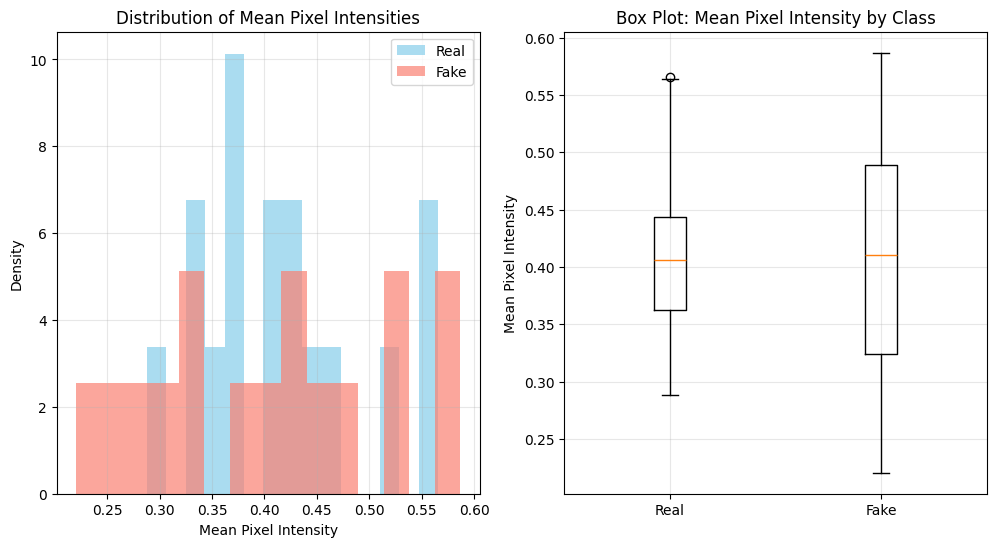

In [ ]:
real_means = [pixel_stats['means'][i] for i in range(len(pixel_stats['means']))
              if pixel_stats['labels'][i] == 'Real']
fake_means = [pixel_stats['means'][i] for i in range(len(pixel_stats['means']))
              if pixel_stats['labels'][i] == 'Fake']
#plt.figure(figsize=(12, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(real_means, bins=15, alpha=0.7, label='Real', color='skyblue', density=True)
ax1.hist(fake_means, bins=15, alpha=0.7, label='Fake', color='salmon', density=True)
ax1.set_xlabel('Mean Pixel Intensity')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Mean Pixel Intensities')
ax1.legend()
ax1.grid(True, alpha=0.3)

real_indices = [i for i, label in enumerate(pixel_stats['labels']) if label == 'Real']
fake_indices = [i for i, label in enumerate(pixel_stats['labels']) if label == 'Fake']

real_stats = [pixel_stats['means'][i] for i in real_indices]
fake_stats = [pixel_stats['means'][i] for i in fake_indices]

box_data = [real_stats, fake_stats]
ax2.boxplot(box_data, labels=['Real', 'Fake'])
ax2.set_ylabel('Mean Pixel Intensity')
ax2.set_title('Box Plot: Mean Pixel Intensity by Class')
ax2.grid(True, alpha=0.3)

In [ ]:
def analyze_rgb_channels(images, labels):
    rgb_stats = {'Real': {'R': [], 'G': [], 'B': []},
                 'Fake': {'R': [], 'G': [], 'B': []}}
    for img, label in zip(images, labels):
        if img.max() > 1.0:
            img = img / 255.0
        class_name = 'Real' if label == 0 else 'Fake'
        rgb_stats[class_name]['R'].append(np.mean(img[:, :, 0]))
        rgb_stats[class_name]['G'].append(np.mean(img[:, :, 1]))
        rgb_stats[class_name]['B'].append(np.mean(img[:, :, 2]))
    return rgb_stats

In [ ]:
rgb_stats = analyze_rgb_channels(sample_images, sample_labels)

Text(0.5, 1.0, 'Mean RGB Channel Values by Class')

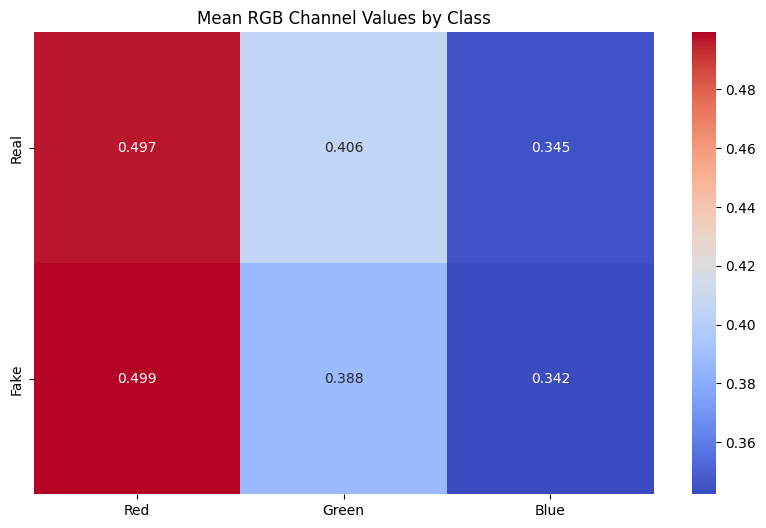

In [ ]:
plt.figure(figsize=(10, 6))
rgb_summary = []
for class_name in ['Real', 'Fake']:
    row = []
    for channel in ['R', 'G', 'B']:
        row.append(np.mean(rgb_stats[class_name][channel]))
    rgb_summary.append(row)
rgb_df = pd.DataFrame(rgb_summary, columns=['Red', 'Green', 'Blue'],
                      index=['Real', 'Fake'])
sns.heatmap(rgb_df, annot=True, fmt='.3f', cmap='coolwarm')
plt.title('Mean RGB Channel Values by Class')

Structured Data: Perform univariate and bivariate analysis of the features

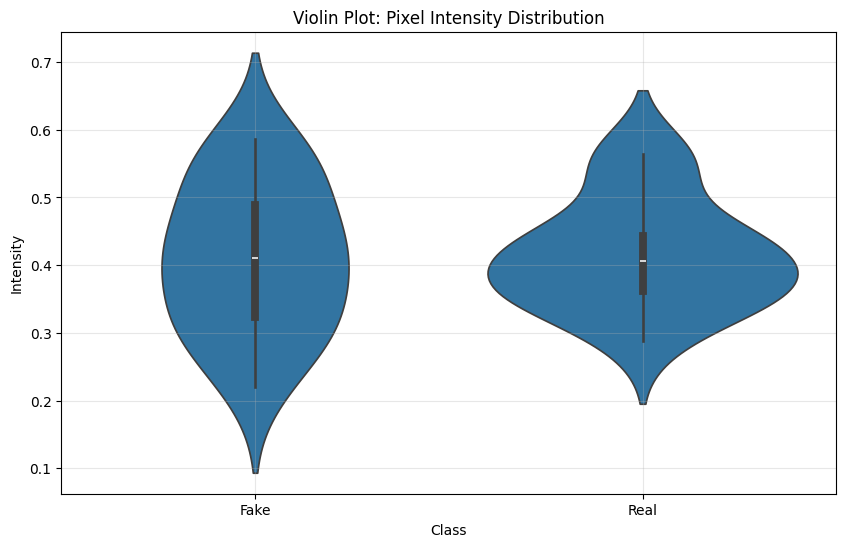

In [ ]:
plt.figure(figsize=(10, 6))
violin_data = []
violin_labels = []
for i, (mean_val, label) in enumerate(zip(pixel_stats['means'], pixel_stats['labels'])):
    violin_data.append(mean_val)
    violin_labels.append(label)
violin_df = pd.DataFrame({'Intensity': violin_data, 'Class': violin_labels})
sns.violinplot(data=violin_df, x='Class', y='Intensity')
plt.title('Violin Plot: Pixel Intensity Distribution')
plt.grid(True, alpha=0.3)

## Cognitive Problem 1: Classifying AI-Generated Faces

### Competing Model 1: CNN (Eugene)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC

# ---------------- Config ----------------
IMG_H, IMG_W = IMG_SIZE
WARMUP_EPOCHS = 5                  # stage 1 (frozen backbone)

# ---------------- Data Augmentation ----------------
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),
], name="augment")

# ---------------- Model ----------------
inputs = layers.Input(shape=(IMG_H, IMG_W, 3), name="input")

# 1) Augment (train-time only)
x = augment(inputs)

# 2) Preprocess to match ImageNet (torch-style): scale→normalize
x = layers.Rescaling(1/255.0, name="rescale")(x)
normalizer = layers.Normalization(
    mean=[0.485, 0.456, 0.406],
    variance=np.square([0.229, 0.224, 0.225]),
    name="imagenet_norm",
)
x = normalizer(x)

# 3) DenseNet121 backbone (no top)
base = DenseNet121(include_top=False, weights="imagenet",
                   input_shape=(IMG_H, IMG_W, 3))
base.trainable = False  # Stage 1: feature extractor
x = base(x)

# 4) Regularized head
h = layers.GlobalAveragePooling2D(name="gap")(x)
h = layers.BatchNormalization(name="bn1")(h)
h = layers.Dropout(0.5, name="drop1")(h)
h = layers.Dense(256, activation="relu",
                 kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                 name="fc")(h)
h = layers.BatchNormalization(name="bn2")(h)
h = layers.Dropout(0.4, name="drop2")(h)
outputs = layers.Dense(1, activation="sigmoid", dtype="float32", name="pred")(h)

model = models.Model(inputs, outputs, name="DenseNet121_transfer")
model.summary()

# ---------------- Compile (stage 1) ----------------
opt1 = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=5e-5)
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)

model.compile(
    optimizer=opt1,
    loss=loss,
    metrics=[
        BinaryAccuracy(name="accuracy"),
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(curve="PR", name="auprc"),
        AUC(name="auroc"),
    ],
)

# ---------------- Callbacks ----------------
ckpt = tf.keras.callbacks.ModelCheckpoint(
    "best_fake_real.keras", save_best_only=True, monitor="val_loss"
)
es = tf.keras.callbacks.EarlyStopping(
    patience=4, restore_best_weights=True, monitor="val_loss"
)
rlr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

# ---------------- Train: Stage 1 (frozen) ----------------
history1 = model.fit(
    train_ds.prefetch(tf.data.AUTOTUNE),
    epochs=WARMUP_EPOCHS,
    validation_data=val_ds.prefetch(tf.data.AUTOTUNE),
    callbacks=[ckpt, es, rlr],
)

# ---------------- Fine-tune: Stage 2 (unfreeze top 25%) ----------------
base.trainable = True
cut = int(0.75 * len(base.layers))  # unfreeze top quarter
for i, layer in enumerate(base.layers):
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False        # keep BN frozen
    else:
        layer.trainable = (i >= cut)

opt2 = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=5e-5)
finetune_metrics = [
    BinaryAccuracy(name="accuracy"),
    Precision(name="precision"),
    Recall(name="recall"),
    AUC(curve="PR", name="auprc"),
    AUC(name="auroc"),
]
model.compile(optimizer=opt2, loss=loss, metrics=finetune_metrics)

history2 = model.fit(
    train_ds.prefetch(tf.data.AUTOTUNE),
    epochs=EPOCHS,
    validation_data=val_ds.prefetch(tf.data.AUTOTUNE),
    callbacks=[ckpt, es, rlr],
)

Model: "DenseNet121_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescale (Rescaling)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ imagenet_norm (Normalization)   │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 5, 5, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 1024)           │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,305,281 (27.87 MB)

 Trainable params: 265,217 (1.01 MB)

 Non-trainable params: 7,040,064 (26.86 MB)

Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 115s 32ms/step - accuracy: 0.6592 - auprc: 0.6966 - auroc: 0.7150 - loss: 0.7321 - precision: 0.6559 - recall: 0.6683 - val_accuracy: 0.7847 - val_auprc: 0.8700 - val_auroc: 0.8712 - val_loss: 0.5235 - val_precision: 0.8218 - val_recall: 0.7271 - learning_rate: 3.0000e-04
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 95s 31ms/step - accuracy: 0.7257 - auprc: 0.7925 - auroc: 0.8009 - loss: 0.5881 - precision: 0.7239 - recall: 0.7334 - val_accuracy: 0.7935 - val_auprc: 0.8805 - val_auroc: 0.8834 - val_loss: 0.5055 - val_precision: 0.8355 - val_recall: 0.7309 - learning_rate: 3.0000e-04
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 96s 31ms/step - accuracy: 0.7382 - auprc: 0.8096 - auroc: 0.8166 - loss: 0.5696 - precision: 0.7373 - recall: 0.7389 - val_accuracy: 0.8087 - val_auprc: 0.8895 - val_auroc: 0.8925 - val_loss: 0.4890 - val_precision: 0.8265 - val_recall: 0.7816 - learning_rate: 3.0000e-04
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 95s 31ms/step - acc

about 50mins

625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step


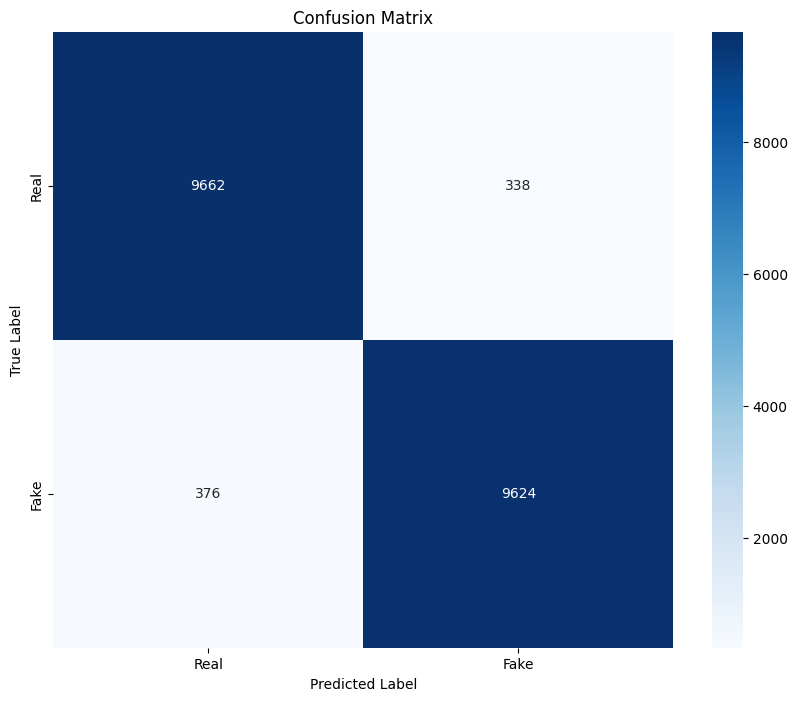


Classification Report:
              precision    recall  f1-score   support

        Real       0.96      0.97      0.96     10000
        Fake       0.97      0.96      0.96     10000

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load the best model
model = tf.keras.models.load_model("/content/best_fake_real.keras")

# Get predictions on test set
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_pred = (model.predict(test_ds).ravel() > 0.5).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

In [ ]:
test_results = model.evaluate(test_ds)

# Unpack the returned values: loss, accuracy, precision, recall, auprc, auroc
test_loss, test_accuracy, test_precision, test_recall, test_auprc, test_auroc = test_results

# Calculate F1-score
if (test_precision + test_recall) > 0:
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
else:
    test_f1 = 0.0

# Print the desired metrics
print("\nTest Set Evaluation Results:")
print(f"  Loss:      {test_loss:.4f}")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print(f"  AUPRC:     {test_auprc:.4f}")
print(f"  AUROC:     {test_auroc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.9666 - auprc: 0.4896 - auroc: 0.4988 - loss: 0.1904 - precision: 0.4422 - recall: 0.4825

Test Set Evaluation Results:
  Loss:      0.1948
  Accuracy:  0.9643
  Precision: 0.9661
  Recall:    0.9624
  F1-Score:  0.9642
  AUPRC:     0.9941
  AUROC:     0.9944


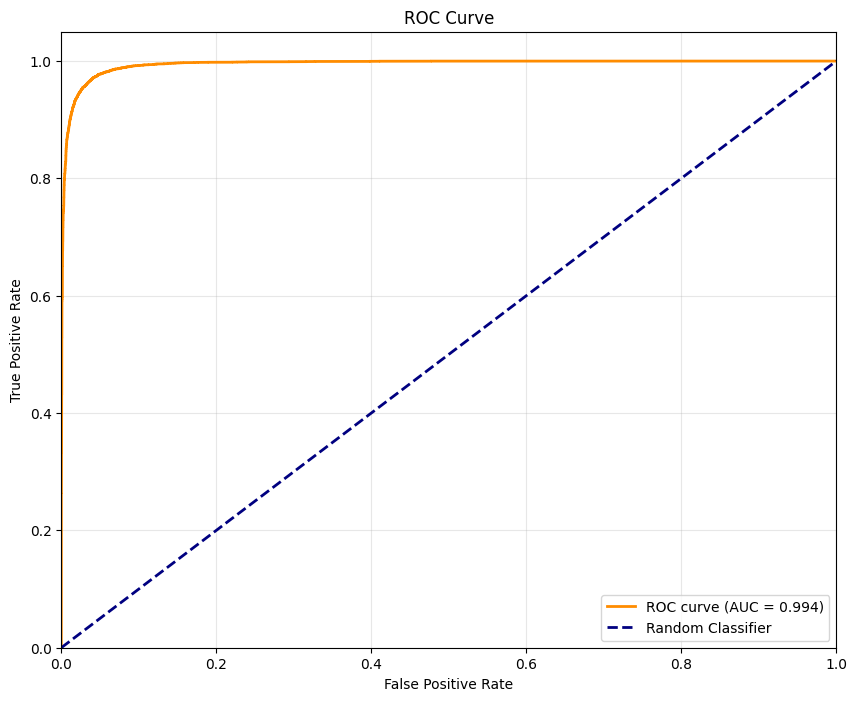

In [ ]:
fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

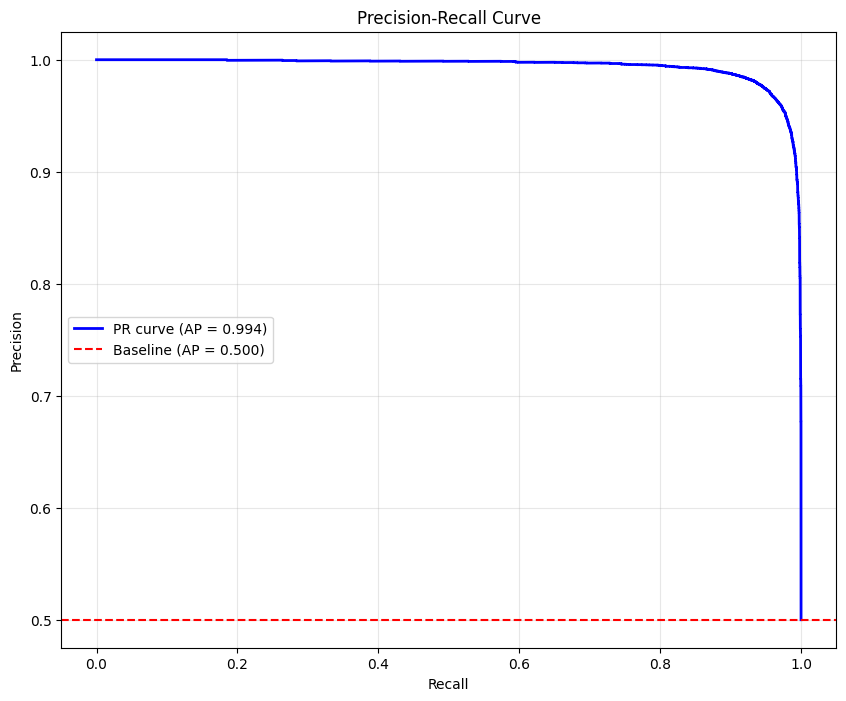

In [ ]:
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_pred_proba)
avg_precision = average_precision_score(y_true, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='blue', lw=2,
          label=f'PR curve (AP = {avg_precision:.3f})')
plt.axhline(y=np.mean(y_true), color='red', linestyle='--',
            label=f'Baseline (AP = {np.mean(y_true):.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

In [ ]:
def predict_single_image(model, image_path):
    # image = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    # image_array = tf.keras.preprocessing.image.img_to_array(image)
    # image_array = tf.expand_dims(image_array, 0)
    # prediction = model.predict(image_array)
    # probability = tf.nn.sigmoid(prediction[0][0]).numpy()
    # if probability > 0.5:
    #     result = f"Fake (confidence: {probability:.4f})"
    # else:
    #     result = f"Real (confidence: {1-probability:.4f})"
    # return result, probability

    img = tf.keras.utils.load_img(image_path, target_size=img_size)
    x = tf.keras.utils.img_to_array(img)          # RGB, 0..255
    x = tf.expand_dims(x, 0)                      # (1,H,W,3)

    p = float(model.predict(x, verbose=0)[0, 0])  # already sigmoid prob of 'fake' (class 1)
    label = 'fake' if p >= 0.5 else 'real'
    confidence = p if label == 'fake' else 1 - p
    return label, confidence

**Fake Images**

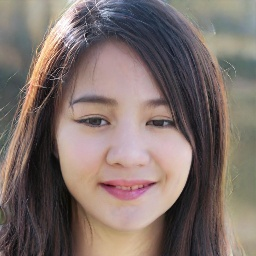

In [ ]:
predict_single_image(model, "/content/fake.jpg")

('fake', 0.9860873818397522)

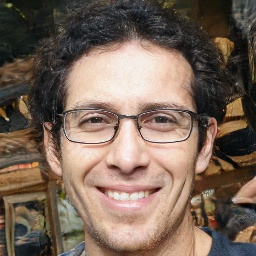

In [ ]:
predict_single_image(model, "/content/fake2.jpg")

('fake', 0.9837732315063477)

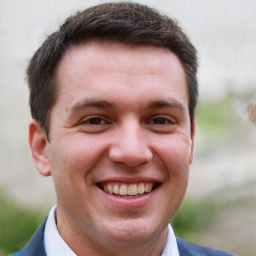

In [ ]:
predict_single_image(model, "/content/fake3.jpg")

('fake', 0.9814838767051697)

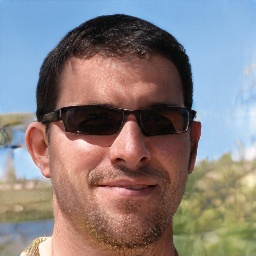

In [ ]:
predict_single_image(model, "/content/fake4.jpg")

('fake', 0.96382737159729)

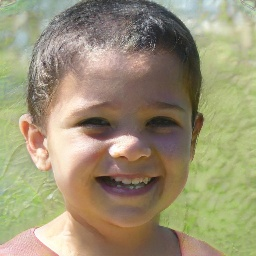

In [ ]:
predict_single_image(model, "/content/fake5.jpg")

('fake', 0.9759592413902283)

**Real Images**

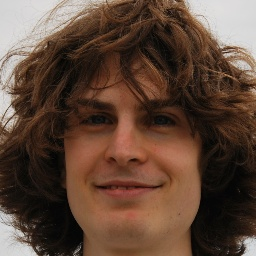

In [ ]:
predict_single_image(model, "/content/real.jpg")

('real', 0.6140132546424866)

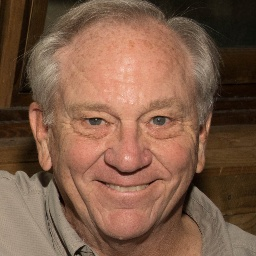

In [ ]:
predict_single_image(model, "/content/real2.jpg")

('real', 0.9431393928825855)

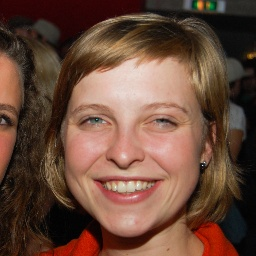

In [ ]:
predict_single_image(model, "/content/real3.jpg")

('real', 0.9662840291857719)

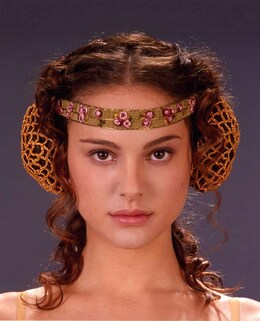

In [ ]:
predict_single_image(model, "/content/real4.jpg")

('real', 0.9761594571173191)

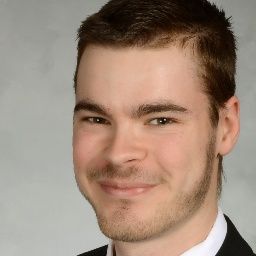

In [ ]:
predict_single_image(model, "/content/real5.jpg")

('real', 0.9755473416298628)

### Competing Model 2: Vision Transformer (Robin)

In [ ]:
PATCH_SIZE = 8  # patch size
NUM_PATCHES = (IMG_SIZE[0] // PATCH_SIZE) ** 2  # patches
PROJECTION_DIM = 64  # patch embeddings
NUM_HEADS = 6  # attention heads
TRANSFORMER_UNITS = [PROJECTION_DIM * 2,PROJECTION_DIM]
TRANSFORMER_LAYERS = 4
MLP_HEAD_UNITS = [1024, 512]

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size,
        })
        return config

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection_dim': self.projection_dim,
        })
        return config

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
def data_augmentation():
    data_aug = keras.Sequential([
        layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.01, width_factor=0.01),
    ], name="data_augmentation")
    return data_aug

In [ ]:
def create_normalization_layer(train_ds):
    normalization_layer = layers.Normalization()
    feature_ds = train_ds.map(lambda x, y: x)
    normalization_layer.adapt(feature_ds)

    return normalization_layer

In [ ]:
def create_vit_classifier(train_ds):
    inputs = layers.Input(shape=IMG_SIZE + (3,))

    augmented = data_augmentation()(inputs)
    patches = Patches(PATCH_SIZE)(augmented)
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    # transformer block
    for _ in range(TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # multi-head attention layer
        attention_output = layers.MultiHeadAttention(num_heads=NUM_HEADS,
                                                     key_dim=PROJECTION_DIM,
                                                     dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.2)(representation)

    # mlp head
    features = layers.Dense(MLP_HEAD_UNITS[0], activation='gelu',
                           kernel_initializer='he_normal')(representation)
    features = layers.Dropout(0.2)(features)
    features = layers.Dense(MLP_HEAD_UNITS[1], activation='gelu',
                           kernel_initializer='he_normal')(features)
    features = layers.Dropout(0.1)(features)

    # classification layer
    if USE_FP16:
        logits = layers.Dense(1, dtype='float32',
                             kernel_initializer='glorot_uniform',
                             bias_initializer='zeros')(features)
    else:
        logits = layers.Dense(1, kernel_initializer='glorot_uniform',
                             bias_initializer='zeros')(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def create_and_compile_model(train_ds):
    model = create_vit_classifier(train_ds)

    optimizer = keras.optimizers.AdamW(
        learning_rate=0.0001,
        weight_decay=0.0001,
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall")
        ],
    )

    return model

In [ ]:
def train_model(model, train_ds, val_ds):
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            min_lr=1e-7,
        ),
        keras.callbacks.ModelCheckpoint(
            filepath="best_vit_model.h5",
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=False,
        ),
    ]

    # Train the model
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=callbacks,
    )

    return history

In [ ]:
def evaluate_model(model, test_ds):
    print("\nEvaluating on test set...")
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds)

    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test precision: {test_precision:.4f}")
    print(f"Test recall: {test_recall:.4f}")
    print(f"Test F1-score: {2 * (test_precision * test_recall) / (test_precision + test_recall):.4f}")

    return test_loss, test_accuracy, test_precision, test_recall

In [ ]:
model = create_and_compile_model(train_ds)

In [ ]:
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 160, 160,  │          0 │ input_layer_18[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_9 (Patches) │ (None, None, 192) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_9     │ (None, 400, 64)   │     37,952 │ patches_9[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 64)   │        128 │ patch_encoder_9[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 400, 64)   │     99,520 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_76 (Add)        │ (None, 400, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 64)   │        128 │ add_76[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_107 (Dense)   │ (None, 400, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_136         │ (None, 400, 128)  │          0 │ dense_107[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_108 (Dense)   │ (None, 400, 64)   │      8,256 │ dropout_136[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_137         │ (None, 400, 64)   │          0 │ dense_108[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_77 (Add)        │ (None, 400, 64)   │          0 │ dropout_137[0][0… │
│                     │                   │            │ add_76[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 64)   │        128 │ add_77[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 400, 64)   │     99,520 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_78 (Add)        │ (None, 400, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_77[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 400, 64)   │        128 │ add_78[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_109 (Dense)   │ (None, 400, 128)  │      8,320 │ layer_normalizat

 Total params: 1,095,361 (4.18 MB)

 Trainable params: 1,095,361 (4.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = train_model(model, train_ds, val_ds)

Epoch 1/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5298 - loss: 0.7049 - precision: 0.5741 - recall: 0.2252

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 478s 149ms/step - accuracy: 0.5299 - loss: 0.7049 - precision: 0.5742 - recall: 0.2253 - val_accuracy: 0.6417 - val_loss: 0.6138 - val_precision: 0.7134 - val_recall: 0.4736 - learning_rate: 1.0000e-04
Epoch 2/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6356 - loss: 0.6134 - precision: 0.7250 - recall: 0.4328

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.6356 - loss: 0.6134 - precision: 0.7250 - recall: 0.4328 - val_accuracy: 0.7196 - val_loss: 0.5726 - val_precision: 0.7261 - val_recall: 0.7050 - learning_rate: 1.0000e-04
Epoch 3/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.7066 - loss: 0.5486 - precision: 0.7823 - recall: 0.5678 - val_accuracy: 0.6669 - val_loss: 0.5581 - val_precision: 0.8809 - val_recall: 0.3861 - learning_rate: 1.0000e-04
Epoch 4/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7512 - loss: 0.4911 - precision: 0.8157 - recall: 0.6470

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 149ms/step - accuracy: 0.7512 - loss: 0.4911 - precision: 0.8157 - recall: 0.6470 - val_accuracy: 0.7622 - val_loss: 0.4725 - val_precision: 0.8336 - val_recall: 0.6552 - learning_rate: 1.0000e-04
Epoch 5/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7740 - loss: 0.4601 - precision: 0.8323 - recall: 0.6852

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 149ms/step - accuracy: 0.7740 - loss: 0.4601 - precision: 0.8323 - recall: 0.6852 - val_accuracy: 0.7875 - val_loss: 0.4585 - val_precision: 0.8158 - val_recall: 0.7426 - learning_rate: 1.0000e-04
Epoch 6/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7905 - loss: 0.4331 - precision: 0.8462 - recall: 0.7065

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.7905 - loss: 0.4331 - precision: 0.8462 - recall: 0.7065 - val_accuracy: 0.7904 - val_loss: 0.4331 - val_precision: 0.8593 - val_recall: 0.6946 - learning_rate: 1.0000e-04
Epoch 7/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8069 - loss: 0.4094 - precision: 0.8582 - recall: 0.7350

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 149ms/step - accuracy: 0.8069 - loss: 0.4094 - precision: 0.8582 - recall: 0.7350 - val_accuracy: 0.8096 - val_loss: 0.4055 - val_precision: 0.8613 - val_recall: 0.7380 - learning_rate: 1.0000e-04
Epoch 8/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.8146 - loss: 0.3944 - precision: 0.8629 - recall: 0.7491 - val_accuracy: 0.7965 - val_loss: 0.4091 - val_precision: 0.9087 - val_recall: 0.6591 - learning_rate: 1.0000e-04
Epoch 9/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8256 - loss: 0.3742 - precision: 0.8739 - recall: 0.7605

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 149ms/step - accuracy: 0.8256 - loss: 0.3742 - precision: 0.8739 - recall: 0.7605 - val_accuracy: 0.8295 - val_loss: 0.4055 - val_precision: 0.8003 - val_recall: 0.8781 - learning_rate: 1.0000e-04
Epoch 10/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.8363 - loss: 0.3597 - precision: 0.8813 - recall: 0.7782 - val_accuracy: 0.8091 - val_loss: 0.3910 - val_precision: 0.8986 - val_recall: 0.6968 - learning_rate: 1.0000e-04
Epoch 11/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8460 - loss: 0.3408 - precision: 0.8867 - recall: 0.7921

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.8460 - loss: 0.3408 - precision: 0.8867 - recall: 0.7921 - val_accuracy: 0.8410 - val_loss: 0.3636 - val_precision: 0.8644 - val_recall: 0.8088 - learning_rate: 1.0000e-04
Epoch 12/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.8491 - loss: 0.3317 - precision: 0.8900 - recall: 0.7983 - val_accuracy: 0.8378 - val_loss: 0.3525 - val_precision: 0.8892 - val_recall: 0.7717 - learning_rate: 1.0000e-04
Epoch 13/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8549 - loss: 0.3203 - precision: 0.8914 - recall: 0.8079

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 149ms/step - accuracy: 0.8549 - loss: 0.3203 - precision: 0.8914 - recall: 0.8079 - val_accuracy: 0.8457 - val_loss: 0.3317 - val_precision: 0.9011 - val_recall: 0.7768 - learning_rate: 1.0000e-04
Epoch 14/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8626 - loss: 0.3072 - precision: 0.8980 - recall: 0.8182

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.8626 - loss: 0.3072 - precision: 0.8980 - recall: 0.8182 - val_accuracy: 0.8564 - val_loss: 0.3337 - val_precision: 0.8635 - val_recall: 0.8466 - learning_rate: 1.0000e-04
Epoch 15/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.8651 - loss: 0.3019 - precision: 0.8996 - recall: 0.8217 - val_accuracy: 0.8551 - val_loss: 0.3158 - val_precision: 0.9022 - val_recall: 0.7965 - learning_rate: 1.0000e-04
Epoch 16/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8691 - loss: 0.2937 - precision: 0.9031 - recall: 0.8275

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.8691 - loss: 0.2937 - precision: 0.9031 - recall: 0.8275 - val_accuracy: 0.8627 - val_loss: 0.3145 - val_precision: 0.8980 - val_recall: 0.8184 - learning_rate: 1.0000e-04
Epoch 17/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 463s 148ms/step - accuracy: 0.8755 - loss: 0.2816 - precision: 0.9099 - recall: 0.8331 - val_accuracy: 0.8618 - val_loss: 0.3207 - val_precision: 0.8735 - val_recall: 0.8462 - learning_rate: 1.0000e-04
Epoch 18/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.8804 - loss: 0.2729 - precision: 0.9134 - recall: 0.8400 - val_accuracy: 0.8555 - val_loss: 0.2953 - val_precision: 0.9385 - val_recall: 0.7610 - learning_rate: 1.0000e-04
Epoch 19/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8831 - loss: 0.2665 - precision: 0.9166 - recall: 0.8425

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 149ms/step - accuracy: 0.8831 - loss: 0.2665 - precision: 0.9166 - recall: 0.8425 - val_accuracy: 0.8640 - val_loss: 0.2880 - val_precision: 0.9326 - val_recall: 0.7848 - learning_rate: 1.0000e-04
Epoch 20/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8899 - loss: 0.2544 - precision: 0.9207 - recall: 0.8538

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 149ms/step - accuracy: 0.8899 - loss: 0.2544 - precision: 0.9207 - recall: 0.8538 - val_accuracy: 0.8845 - val_loss: 0.2803 - val_precision: 0.8921 - val_recall: 0.8749 - learning_rate: 1.0000e-04
Epoch 21/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8896 - loss: 0.2539 - precision: 0.9198 - recall: 0.8544

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.8896 - loss: 0.2539 - precision: 0.9198 - recall: 0.8544 - val_accuracy: 0.8903 - val_loss: 0.2627 - val_precision: 0.8968 - val_recall: 0.8821 - learning_rate: 1.0000e-04
Epoch 22/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.8951 - loss: 0.2429 - precision: 0.9246 - recall: 0.8612 - val_accuracy: 0.8840 - val_loss: 0.2767 - val_precision: 0.9103 - val_recall: 0.8520 - learning_rate: 1.0000e-04
Epoch 23/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.8973 - loss: 0.2384 - precision: 0.9246 - recall: 0.8639 - val_accuracy: 0.8713 - val_loss: 0.2896 - val_precision: 0.9293 - val_recall: 0.8039 - learning_rate: 1.0000e-04
Epoch 24/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.9017 - loss: 0.2310 - precision: 0.9278 - recall: 0.8708 - val_accuracy: 0.8869 - val_loss: 0.3018 - val_precision: 0.8741 - val_recall: 0.9040 - learning_rate: 1.0000e-04
Epoch 25/30
3125/3125 ━━━━━━━━━━

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 149ms/step - accuracy: 0.9109 - loss: 0.2094 - precision: 0.9345 - recall: 0.8831 - val_accuracy: 0.9000 - val_loss: 0.2560 - val_precision: 0.9018 - val_recall: 0.8977 - learning_rate: 5.0000e-05
Epoch 26/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9173 - loss: 0.1950 - precision: 0.9392 - recall: 0.8920

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 149ms/step - accuracy: 0.9173 - loss: 0.1950 - precision: 0.9392 - recall: 0.8920 - val_accuracy: 0.9031 - val_loss: 0.2396 - val_precision: 0.9192 - val_recall: 0.8838 - learning_rate: 5.0000e-05
Epoch 27/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.9208 - loss: 0.1896 - precision: 0.9427 - recall: 0.8957 - val_accuracy: 0.9004 - val_loss: 0.2482 - val_precision: 0.9157 - val_recall: 0.8821 - learning_rate: 5.0000e-05
Epoch 28/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 148ms/step - accuracy: 0.9215 - loss: 0.1846 - precision: 0.9411 - recall: 0.8998 - val_accuracy: 0.9007 - val_loss: 0.2411 - val_precision: 0.9257 - val_recall: 0.8712 - learning_rate: 5.0000e-05
Epoch 29/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9233 - loss: 0.1831 - precision: 0.9448 - recall: 0.8993

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 149ms/step - accuracy: 0.9233 - loss: 0.1831 - precision: 0.9448 - recall: 0.8993 - val_accuracy: 0.9033 - val_loss: 0.2465 - val_precision: 0.9161 - val_recall: 0.8879 - learning_rate: 5.0000e-05
Epoch 30/30
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9325 - loss: 0.1644 - precision: 0.9513 - recall: 0.9115

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 464s 149ms/step - accuracy: 0.9325 - loss: 0.1644 - precision: 0.9513 - recall: 0.9115 - val_accuracy: 0.9057 - val_loss: 0.2369 - val_precision: 0.9241 - val_recall: 0.8840 - learning_rate: 2.5000e-05


(took 4 hours and 30 minutes to train)

In [ ]:
evaluate_model(model, test_ds)


Evaluating on test set...
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9192 - loss: 0.2464 - precision: 0.3922 - recall: 0.4457
Test accuracy: 0.9056
Test precision: 0.9204
Test recall: 0.8879
Test F1-score: 0.9039


(0.2425488531589508,
 0.9055500030517578,
 0.9203897714614868,
 0.8878999948501587)

In [ ]:
#model.save("vit_08_05_2025.h5")

**Evaluation**

In [ ]:
test_results = model.evaluate(test_ds, verbose=1)
test_loss, test_accuracy, test_precision, test_recall = test_results

625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9192 - loss: 0.2464 - precision: 0.3922 - recall: 0.4457


In [ ]:
if test_precision + test_recall > 0:
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
else:
    test_f1 = 0

print(f"\nTest Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test F1-Score:  {test_f1:.4f}")


Test Loss:      0.2425
Test Accuracy:  0.9056 (90.56%)
Test Precision: 0.9204
Test Recall:    0.8879
Test F1-Score:  0.9039


In [ ]:
y_true = []
y_pred_proba = []
y_pred = []

for batch_idx, (images, labels) in enumerate(test_ds):
    if batch_idx % 10 == 0:
        print(f"  Batch {batch_idx + 1}/{len(test_ds)}")

    # Get predictions (logits)
    predictions_logits = model(images, training=False)
    # Convert to probabilities
    predictions_proba = tf.nn.sigmoid(predictions_logits)
    # Convert to binary predictions (0.5 threshold)
    predictions_binary = (predictions_proba > 0.5).numpy().astype(int)

    y_true.extend(labels.numpy().astype(int))
    y_pred_proba.extend(predictions_proba.numpy().flatten())
    y_pred.extend(predictions_binary.flatten())

y_true = np.array(y_true)
y_pred_proba = np.array(y_pred_proba)
y_pred = np.array(y_pred)

  Batch 1/625
  Batch 11/625
  Batch 21/625
  Batch 31/625
  Batch 41/625
  Batch 51/625
  Batch 61/625
  Batch 71/625
  Batch 81/625
  Batch 91/625
  Batch 101/625
  Batch 111/625
  Batch 121/625
  Batch 131/625
  Batch 141/625
  Batch 151/625
  Batch 161/625
  Batch 171/625
  Batch 181/625
  Batch 191/625
  Batch 201/625
  Batch 211/625
  Batch 221/625
  Batch 231/625
  Batch 241/625
  Batch 251/625
  Batch 261/625
  Batch 271/625
  Batch 281/625
  Batch 291/625
  Batch 301/625
  Batch 311/625
  Batch 321/625
  Batch 331/625
  Batch 341/625
  Batch 351/625
  Batch 361/625
  Batch 371/625
  Batch 381/625
  Batch 391/625
  Batch 401/625
  Batch 411/625
  Batch 421/625
  Batch 431/625
  Batch 441/625
  Batch 451/625
  Batch 461/625
  Batch 471/625
  Batch 481/625
  Batch 491/625
  Batch 501/625
  Batch 511/625
  Batch 521/625
  Batch 531/625
  Batch 541/625
  Batch 551/625
  Batch 561/625
  Batch 571/625
  Batch 581/625
  Batch 591/625
  Batch 601/625
  Batch 611/625
  Batch 621/625


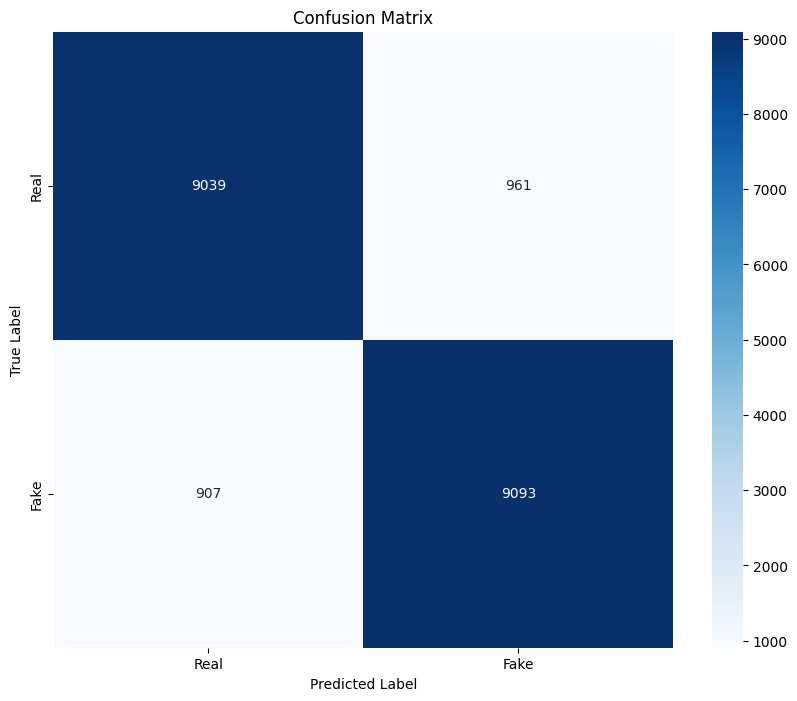

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

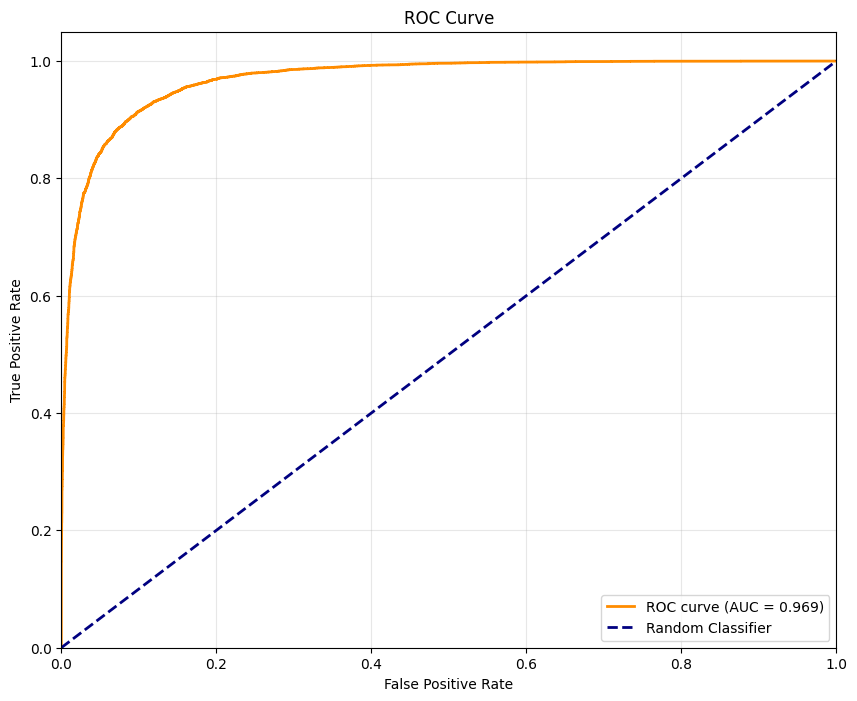

In [ ]:
fpr, tpr, roc_thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

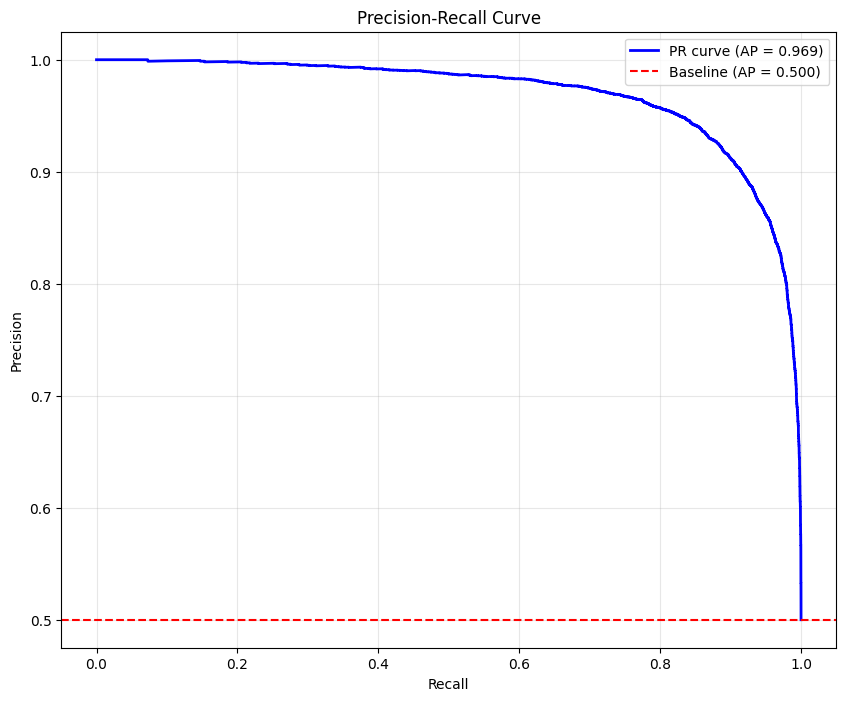

In [ ]:
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_pred_proba)
avg_precision = average_precision_score(y_true, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='blue', lw=2,
          label=f'PR curve (AP = {avg_precision:.3f})')
plt.axhline(y=np.mean(y_true), color='red', linestyle='--',
            label=f'Baseline (AP = {np.mean(y_true):.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

In [ ]:
class_names = ['Real', 'Fake']
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

        Real     0.9088    0.9039    0.9063     10000
        Fake     0.9044    0.9093    0.9069     10000

    accuracy                         0.9066     20000
   macro avg     0.9066    0.9066    0.9066     20000
weighted avg     0.9066    0.9066    0.9066     20000



In [ ]:
def predict_single_image(model, image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    image_array = tf.expand_dims(image_array, 0)
    prediction = model.predict(image_array)
    probability = tf.nn.sigmoid(prediction[0][0]).numpy()
    if probability > 0.5:
        result = f"Fake (confidence: {probability:.4f})"
    else:
        result = f"Real (confidence: {1-probability:.4f})"
    return result, probability

**Fake Images**

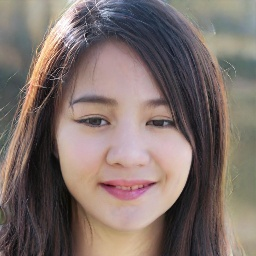

In [ ]:
predict_single_image(model, "/content/fake.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


('Fake (confidence: 0.9995)', np.float32(0.9995135))

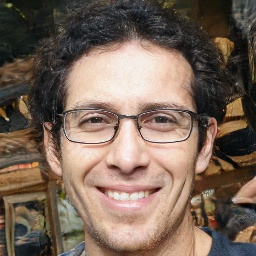

In [ ]:
predict_single_image(model, "/content/fake2.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


('Fake (confidence: 0.9945)', np.float32(0.9944748))

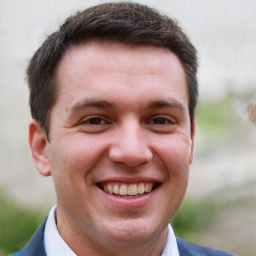

In [ ]:
predict_single_image(model, "/content/fake3.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


('Fake (confidence: 0.9985)', np.float32(0.9984875))

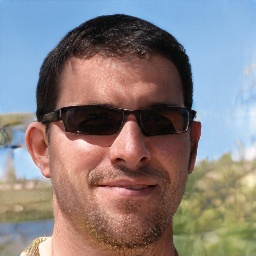

In [ ]:
predict_single_image(model, "/content/fake4.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


('Fake (confidence: 0.9991)', np.float32(0.99914))

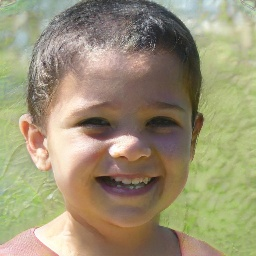

In [ ]:
predict_single_image(model, "/content/fake5.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


('Fake (confidence: 0.9941)', np.float32(0.9940785))

**Real Images**

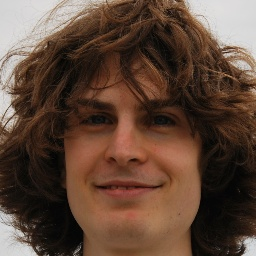

In [ ]:
predict_single_image(model, "/content/real.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


('Real (confidence: 0.9882)', np.float32(0.0118469335))

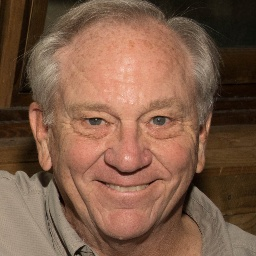

In [ ]:
predict_single_image(model, "/content/real2.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


('Real (confidence: 0.9535)', np.float32(0.046482276))

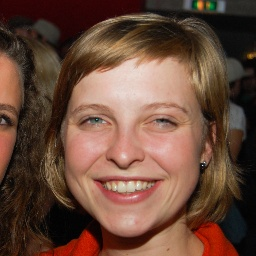

In [ ]:
predict_single_image(model, "/content/real3.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


('Real (confidence: 0.9966)', np.float32(0.003397182))

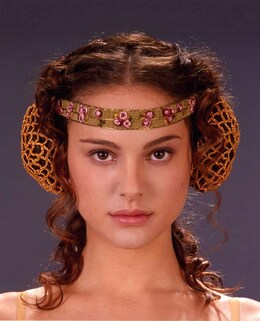

In [ ]:
predict_single_image(model, "/content/real4.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


('Real (confidence: 1.0000)', np.float32(4.2214673e-05))

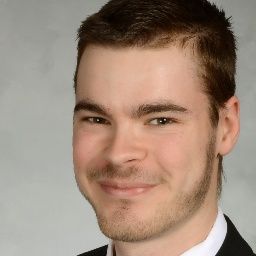

In [ ]:
predict_single_image(model, "/content/real5.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


('Real (confidence: 0.9970)', np.float32(0.0029830658))

## Cognitive Problem 2: Facial Segmentation

### Competing Model 1: [Pre-trained Face Landmarker] (Nick)

I am starting with a facial landmark recognition model, within object detection. Would like to see if we can detect eyes, nose, ears on faces

In [ ]:
# for MediaPipe Face Landmarker designed for real-time face detection in image
!pip install mediapipe

In [ ]:
import mediapipe as mp
import numpy as np
import urllib.request
import pandas as pd
import os
import cv2

from scipy.spatial.distance import euclidean
from scipy.io import loadmat
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import ImageFormat
from mediapipe.framework.formats import landmark_pb2

In [ ]:
# Download the pre-trained model file
model_url = "https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task"
model_path = 'face_landmarker.task'
urllib.request.urlretrieve(model_url, model_path)

# Set up the MediaPipe Face Landmarker model
base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

In [ ]:
# use the 'extract_samples' function from above in the notebook
sample_images, _ = extract_samples(train_ds, 10)
#image = sample_images[0]

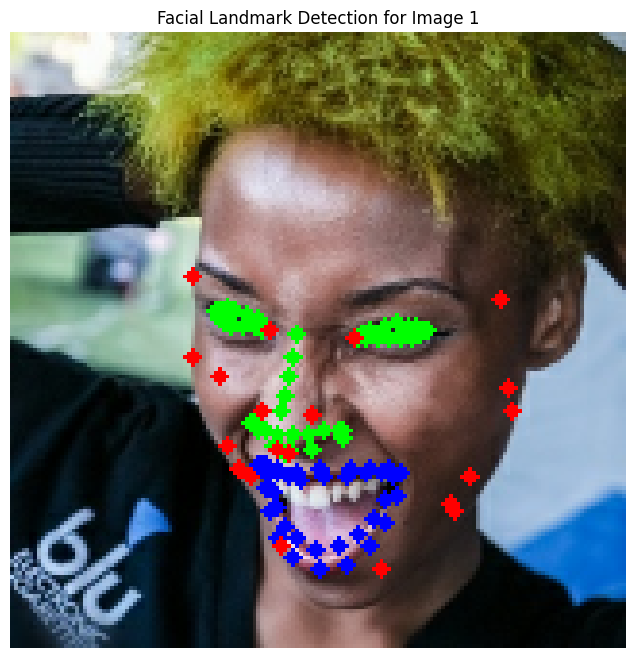

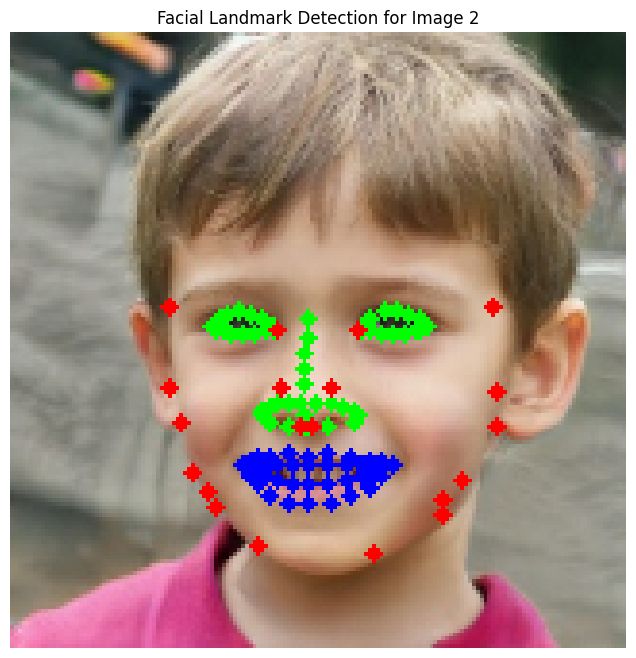

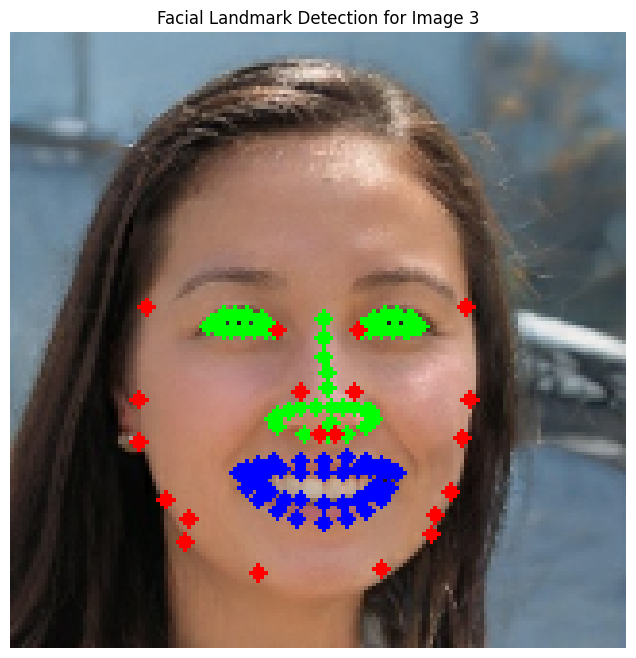

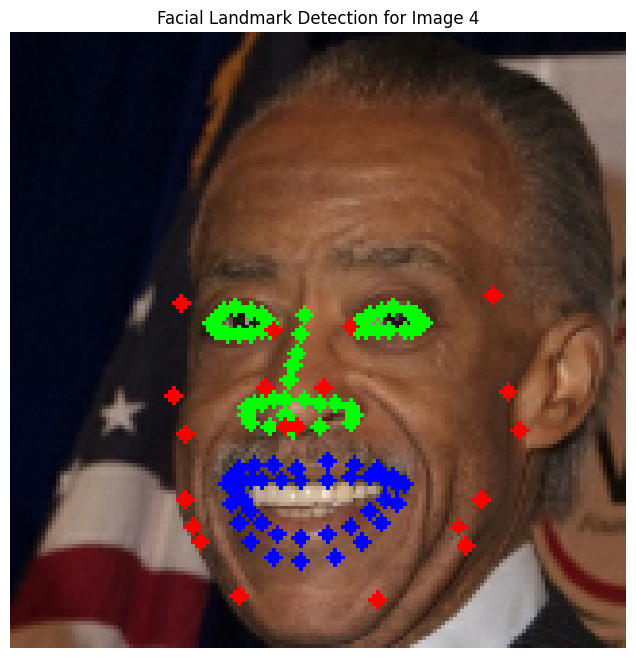

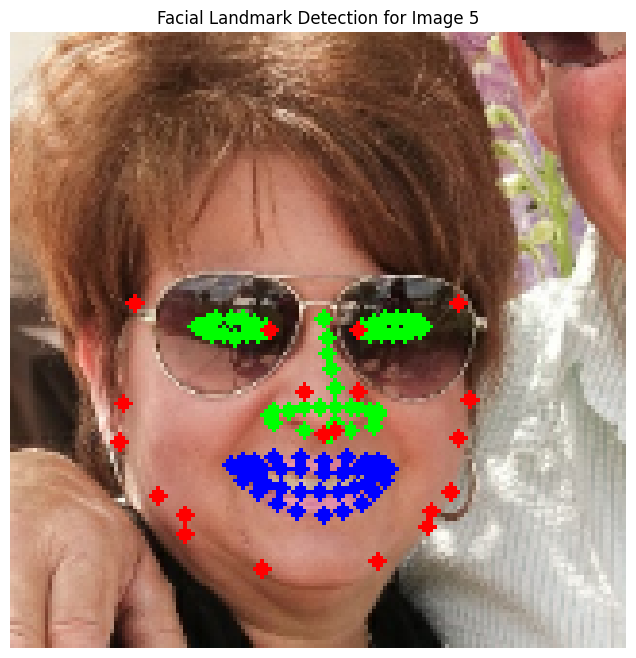

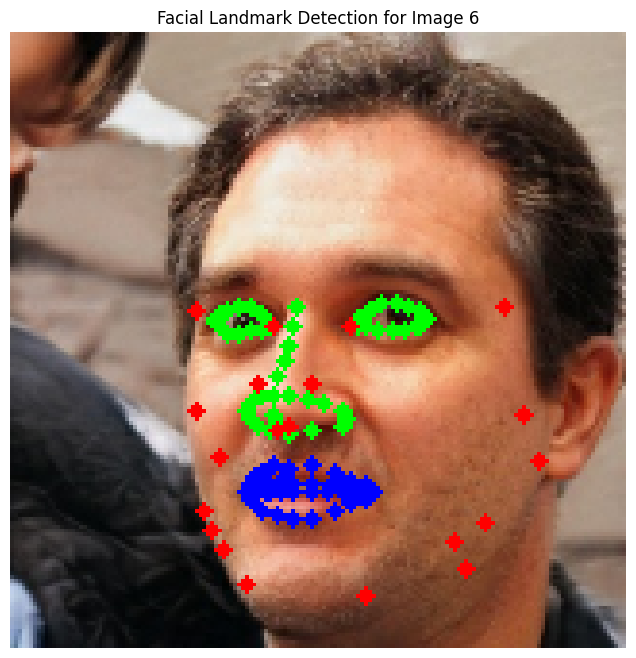

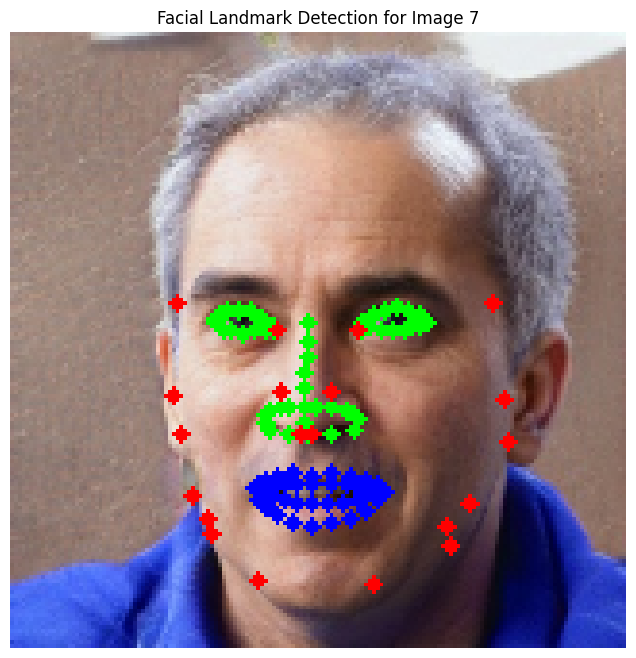

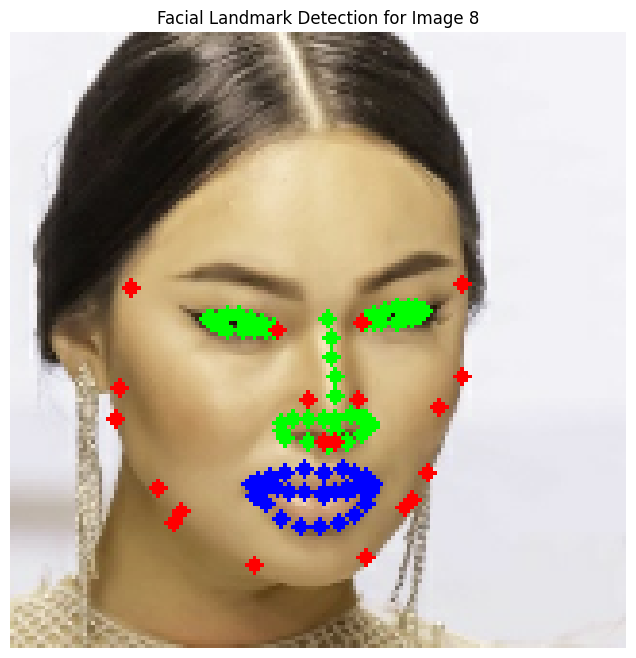

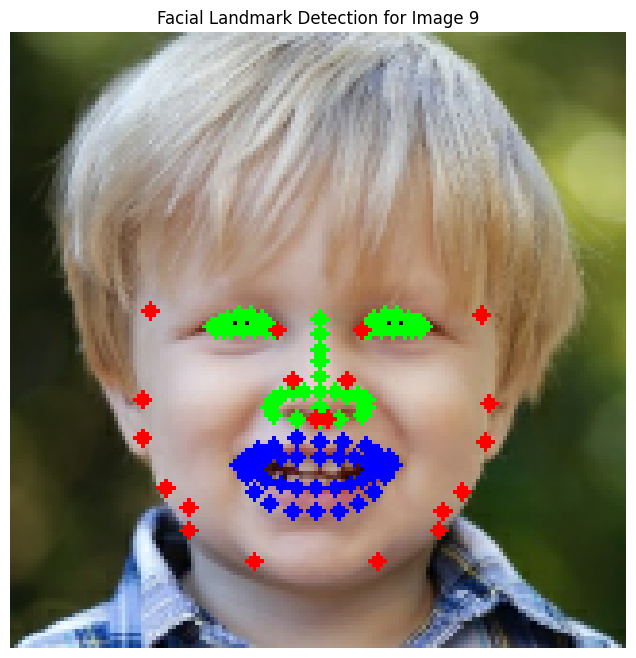

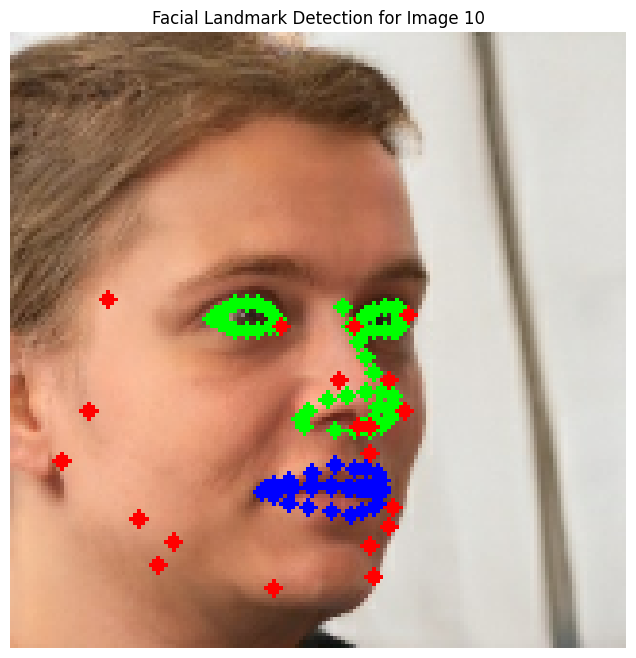

In [ ]:
# Iterate through each image and perform detection
for i, image in enumerate(sample_images):
    # Convert the image to a MediaPipe Image object (it needs to be RGB)
    image_rgb = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=ImageFormat.SRGB, data=image_rgb)

    # Perform facial landmark detection
    detection_result = detector.detect(mp_image)

    # 5. Check if a face was detected and draw landmarks
    if detection_result.face_landmarks:
        landmarks = detection_result.face_landmarks[0]

        # Draw the landmarks on a copy of the image
        annotated_image = np.copy(image_rgb)

        def draw_landmarks_on_image(img, landmark_list, color=(0, 255, 0)):
            for landmark in landmark_list:
                h, w, _ = img.shape
                x = int(landmark.x * w)
                y = int(landmark.y * h)
                cv2.circle(img, (x, y), 2, color, -1)

        # Correctly extract unique landmark indices for eyes, nose, and lips
        left_eye_indices = {i for pair in mp.solutions.face_mesh.FACEMESH_LEFT_EYE for i in pair}
        right_eye_indices = {i for pair in mp.solutions.face_mesh.FACEMESH_RIGHT_EYE for i in pair}
        nose_indices = {i for pair in mp.solutions.face_mesh.FACEMESH_NOSE for i in pair}
        lips_indices = {i for pair in mp.solutions.face_mesh.FACEMESH_LIPS for i in pair}

        # Manually extract ear indices from FACEMESH_FACE_OVAL
        # These indices correspond to the general area of the ears and jawline
        left_ear_indices = {132, 133, 134, 135, 136, 137, 138, 139, 140, 141} # Approximate
        right_ear_indices = {361, 362, 363, 364, 365, 366, 367, 368, 369, 370} # Approximate

        # Get the actual landmark points
        left_eye_landmarks = [landmarks[i] for i in left_eye_indices if i < len(landmarks)]
        right_eye_landmarks = [landmarks[i] for i in right_eye_indices if i < len(landmarks)]
        nose_landmarks = [landmarks[i] for i in nose_indices if i < len(landmarks)]
        lips_landmarks = [landmarks[i] for i in lips_indices if i < len(landmarks)]
        left_ear_landmarks = [landmarks[i] for i in left_ear_indices if i < len(landmarks)]
        right_ear_landmarks = [landmarks[i] for i in right_ear_indices if i < len(landmarks)]

        # Draw the landmarks for eyes and nose (green), mouth (blue), and ears (red)
        draw_landmarks_on_image(annotated_image, left_eye_landmarks, color=(0, 255, 0)) # Green
        draw_landmarks_on_image(annotated_image, right_eye_landmarks, color=(0, 255, 0)) # Green
        draw_landmarks_on_image(annotated_image, nose_landmarks, color=(0, 255, 0)) # Green
        draw_landmarks_on_image(annotated_image, lips_landmarks, color=(255, 0, 0)) # Blue
        draw_landmarks_on_image(annotated_image, left_ear_landmarks, color=(0, 0, 255)) # Red
        draw_landmarks_on_image(annotated_image, right_ear_landmarks, color=(0, 0, 255)) # Red

        # Show the annotated image
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))
        plt.title(f'Facial Landmark Detection for Image {i+1}')
        plt.axis('off')
        plt.show()
    else:
        print(f"No face detected in Image {i+1}.")

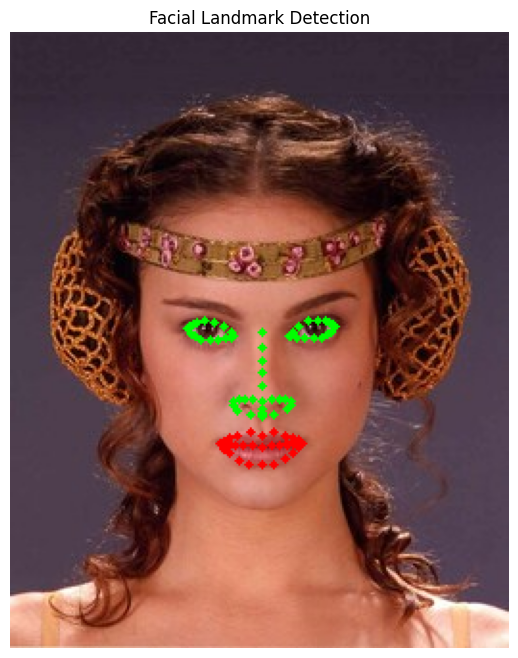

In [ ]:
# Using the Starwars image example
image_path = '/content/real3.jpeg'

if not os.path.exists(image_path):
    print(f"Error: Image not found at {image_path}")
else:
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read the image file at {image_path}")
    else:
        # 4. Process the image
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=ImageFormat.SRGB, data=image_rgb)
        detection_result = detector.detect(mp_image)

        # 5. Draw landmarks if a face is detected
        if detection_result.face_landmarks:
            landmarks = detection_result.face_landmarks[0]
            annotated_image = np.copy(image_rgb)

            def draw_landmarks_on_image(img, landmark_list, color=(0, 255, 0)):
                for landmark in landmark_list:
                    h, w, _ = img.shape
                    x = int(landmark.x * w)
                    y = int(landmark.y * h)
                    cv2.circle(img, (x, y), 2, color, -1)

            # Correctly extract unique landmark indices for specific features
            left_eye_indices = {i for pair in mp.solutions.face_mesh.FACEMESH_LEFT_EYE for i in pair}
            right_eye_indices = {i for pair in mp.solutions.face_mesh.FACEMESH_RIGHT_EYE for i in pair}
            nose_indices = {i for pair in mp.solutions.face_mesh.FACEMESH_NOSE for i in pair}
            lips_indices = {i for pair in mp.solutions.face_mesh.FACEMESH_LIPS for i in pair}

            # Get the actual landmark points
            left_eye_landmarks = [landmarks[i] for i in left_eye_indices]
            right_eye_landmarks = [landmarks[i] for i in right_eye_indices]
            nose_landmarks = [landmarks[i] for i in nose_indices]
            lips_landmarks = [landmarks[i] for i in lips_indices]

            # Draw the landmarks for eyes and nose (green), mouth (blue)
            draw_landmarks_on_image(annotated_image, left_eye_landmarks, color=(0, 255, 0))
            draw_landmarks_on_image(annotated_image, right_eye_landmarks, color=(0, 255, 0))
            draw_landmarks_on_image(annotated_image, nose_landmarks, color=(0, 255, 0))
            draw_landmarks_on_image(annotated_image, lips_landmarks, color=(255, 0, 0))

            # Show the annotated image
            plt.figure(figsize=(8, 8))
            plt.imshow(annotated_image) # The fix is here.
            plt.title('Facial Landmark Detection')
            plt.axis('off')
            plt.show()
        else:
            print("No face detected in the image.")

### Competing Model 2: BiSeNet (Sajan)

In [ ]:
#pip install torch torchvision opencv-python numpy

In [ ]:
import os, cv2, math, numpy as np, torch, torch.nn as nn
import torch.nn.functional as F
from typing import Dict, Tuple, Optional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DEVICE = "cuda"
WEIGHTS_PATH = "/content/drive/MyDrive/79999_iter.pth"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Labels we care about
NOSE_IDX   = [10]
EYES_L_IDX = [4]
EYES_R_IDX = [5]
MOUTH_IDX  = [11,12,13]

class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, ks=3, stride=1, pad=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, ks, stride, pad, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x): return self.relu(self.bn(self.conv(x)))

class BiSeNetOutput(nn.Module):
    def __init__(self, in_ch, mid_ch, n_classes):
        super().__init__()
        self.conv = ConvBNReLU(in_ch, mid_ch, ks=3, stride=1, pad=1)
        self.conv_out = nn.Conv2d(mid_ch, n_classes, 1, bias=False)
    def forward(self, x): return self.conv_out(self.conv(x))

def conv3x3(in_ch, out_ch, stride=1):
    return nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1   = nn.BatchNorm2d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2   = nn.BatchNorm2d(planes)
        self.downsample = downsample
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        return self.relu(out + identity)

class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        self.layer1 = self._make_layer(64,  2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
    def _make_layer(self, planes, blocks, stride=1):
        down = None
        if stride != 1 or self.inplanes != planes:
            down = nn.Sequential(nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                                 nn.BatchNorm2d(planes))
        layers = [BasicBlock(self.inplanes, planes, stride, down)]
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.inplanes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        feat4  = self.layer1(x)
        feat8  = self.layer2(feat4)
        feat16 = self.layer3(feat8)
        feat32 = self.layer4(feat16)
        return feat8, feat16, feat32

class AttentionRefinementModule(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = ConvBNReLU(in_ch, out_ch, ks=3, stride=1, pad=1)
        self.conv_atten = nn.Conv2d(out_ch, out_ch, 1, bias=False)
        self.bn_atten   = nn.BatchNorm2d(out_ch)
        self.sigmoid    = nn.Sigmoid()
    def forward(self, x):
        x = self.conv(x)
        att = F.adaptive_avg_pool2d(x, 1)
        att = self.sigmoid(self.bn_atten(self.conv_atten(att)))
        return x * att

class FeatureFusionModule(nn.Module):
    def __init__(self, in_sp, in_cp, out_ch):
        super().__init__()
        self.convblk = ConvBNReLU(in_sp + in_cp, out_ch, ks=1, stride=1, pad=0)
        self.conv1   = nn.Conv2d(out_ch, out_ch // 4, 1, bias=False)
        self.conv2   = nn.Conv2d(out_ch // 4, out_ch, 1, bias=False)
        self.relu    = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
    def forward(self, sp, cp):
        if sp.shape[2:] != cp.shape[2:]:
            cp = F.interpolate(cp, size=sp.shape[2:], mode='bilinear', align_corners=False)
        feat = self.convblk(torch.cat([sp, cp], dim=1))
        att  = self.sigmoid(self.conv2(self.relu(self.conv1(feat))))
        return feat + feat * att



class ContextPath(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = ResNet18()
        self.arm16  = AttentionRefinementModule(256, 128)
        self.arm32  = AttentionRefinementModule(512, 128)
        self.conv_avg   = ConvBNReLU(512, 128, ks=1, stride=1, pad=0)
        self.conv_head16 = ConvBNReLU(128, 128, ks=3, stride=1, pad=1)
        self.conv_head32 = ConvBNReLU(128, 128, ks=3, stride=1, pad=1)
    def forward(self, x):
        feat8, feat16, feat32 = self.resnet(x)
        avg = F.adaptive_avg_pool2d(feat32, 1)
        avg = self.conv_avg(avg)
        avg = F.interpolate(avg, size=feat32.shape[2:], mode='nearest')
        feat32_arm  = self.arm32(feat32) + avg
        feat32_head = self.conv_head32(feat32_arm)
        feat32_up   = F.interpolate(feat32_head, size=feat16.shape[2:], mode='bilinear', align_corners=False)
        feat16_arm  = self.arm16(feat16) + feat32_up
        feat16_head = self.conv_head16(feat16_arm)
        return feat8, feat16_head, feat32_head

class BiSeNet(nn.Module):
    def __init__(self, n_classes=19):
        super().__init__()
        self.cp  = ContextPath()
        self.ffm = FeatureFusionModule(128, 128, 256)
        self.conv_out   = BiSeNetOutput(256, 256, n_classes)
        self.conv_out16 = BiSeNetOutput(128, 64,  n_classes)
        self.conv_out32 = BiSeNetOutput(128, 64,  n_classes)
    def forward(self, x):
        H, W = x.shape[2:]
        feat8, feat16, feat32 = self.cp(x)
        feat16_up = F.interpolate(feat16, size=feat8.shape[2:], mode='bilinear', align_corners=False)
        feat_fuse = self.ffm(feat8, feat16_up)
        out   = self.conv_out(feat_fuse)
        out16 = self.conv_out16(feat16)
        out32 = self.conv_out32(feat32)
        out   = F.interpolate(out,   size=(H,W), mode='bilinear', align_corners=False)
        out16 = F.interpolate(out16, size=(H,W), mode='bilinear', align_corners=False)
        out32 = F.interpolate(out32, size=(H,W), mode='bilinear', align_corners=False)
        return out, out16, out32


MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

def preprocess(img_bgr, target=512):
    h, w = img_bgr.shape[:2]
    s = target / max(h, w)
    nh, nw = int(round(h*s)), int(round(w*s))
    img = cv2.resize(img_bgr, (nw, nh), interpolation=cv2.INTER_LINEAR)
    img = cv2.copyMakeBorder(img, 0, target-nh, 0, target-nw, cv2.BORDER_CONSTANT, value=(0,0,0))
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    ten = torch.from_numpy(rgb.transpose(2,0,1)).unsqueeze(0)
    ten = (ten - MEAN) / STD
    return ten, (nh, nw)

def to_seg(logits, orig_hw, scaled_hw):
    seg = logits.softmax(1)[0].argmax(0).cpu().numpy().astype(np.uint8)
    nh, nw = scaled_hw
    seg = seg[0:nh, 0:nw]
    H, W = orig_hw
    return cv2.resize(seg, (W, H), interpolation=cv2.INTER_NEAREST)

def mask_and_box(seg, idxs):
    m = (np.isin(seg, idxs)).astype(np.uint8)*255
    ys, xs = np.where(m>0)
    if ys.size == 0: return m, None
    return m, (int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max()))

def draw(img, boxes: Dict[str,Tuple[int,int,int,int]], masks: Dict[str,np.ndarray], alpha=0.35):
    out = img.copy()
    colors = {"nose":(0,165,255), "mouth":(0,0,255), "left_eye":(0,255,0), "right_eye":(255,0,0)}
    if masks:
        overlay = out.copy()
        for k,m in masks.items():
            if m is None: continue
            c = np.array(colors.get(k,(255,255,255)), dtype=np.float32)
            overlay[m>0] = (0.65*overlay[m>0] + 0.35*c).astype(np.uint8)
        out = cv2.addWeighted(overlay, alpha, out, 1-alpha, 0)
    for k,b in boxes.items():
        if b is None: continue
        x1,y1,x2,y2 = b
        cv2.rectangle(out,(x1,y1),(x2,y2),colors.get(k,(255,255,255)),2)
        cv2.putText(out,k,(x1,max(15,y1-6)),cv2.FONT_HERSHEY_SIMPLEX,0.5,colors.get(k,(255,255,255)),1,cv2.LINE_AA)
    return out


model = BiSeNet(n_classes=19).to(DEVICE).eval()

state = torch.load(WEIGHTS_PATH, map_location="cpu")
sd = state["state_dict"] if isinstance(state, dict) and "state_dict" in state else state
sd = {k.replace("module.", ""): v for k, v in sd.items()}

res = model.load_state_dict(sd, strict=False)
print(f"Loaded on {DEVICE}. Missing: {len(res.missing_keys)}, Unexpected: {len(res.unexpected_keys)}")


Loaded on cuda. Missing: 0, Unexpected: 0


In [ ]:
sample_images, _ = extract_samples(train_ds, 10)

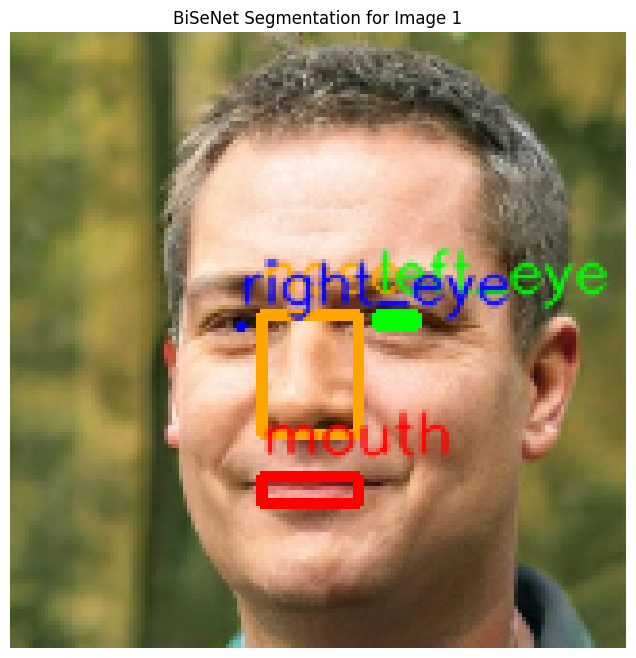

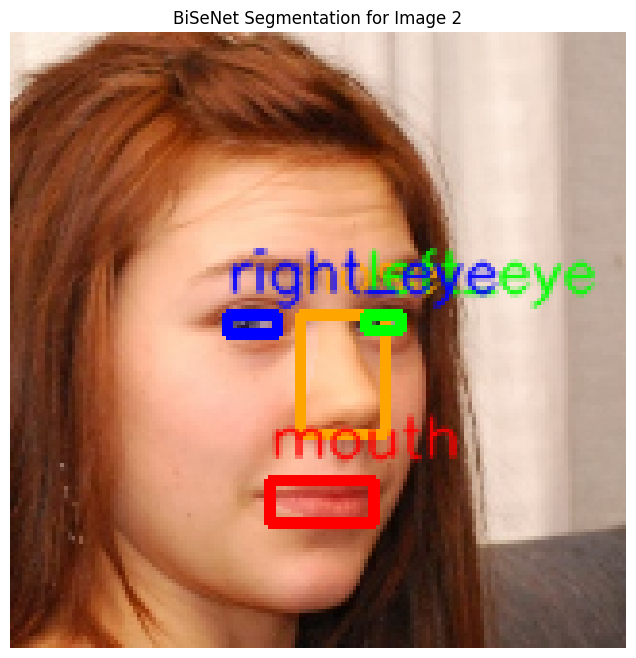

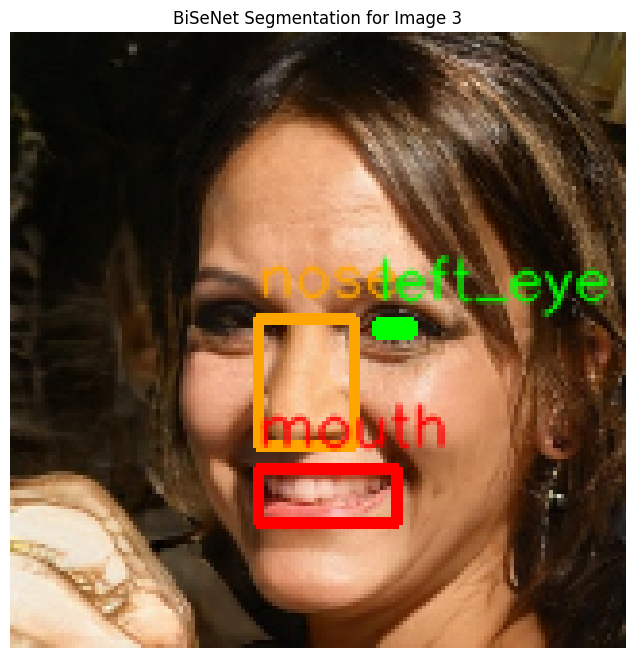

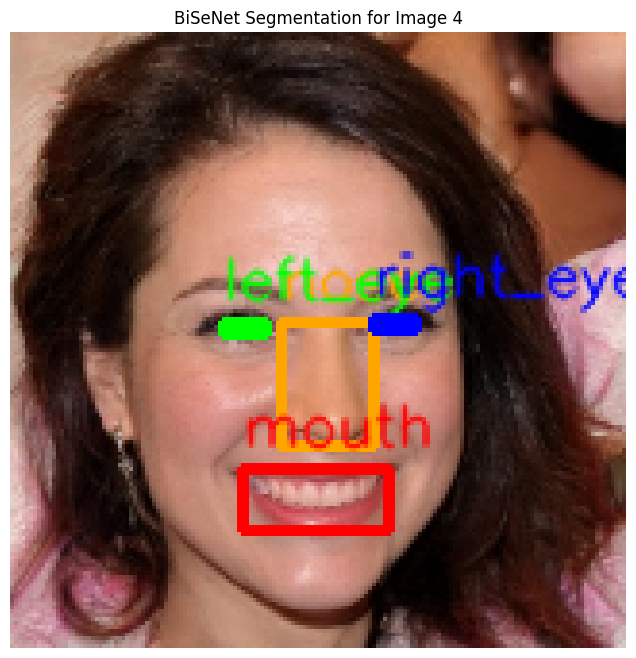

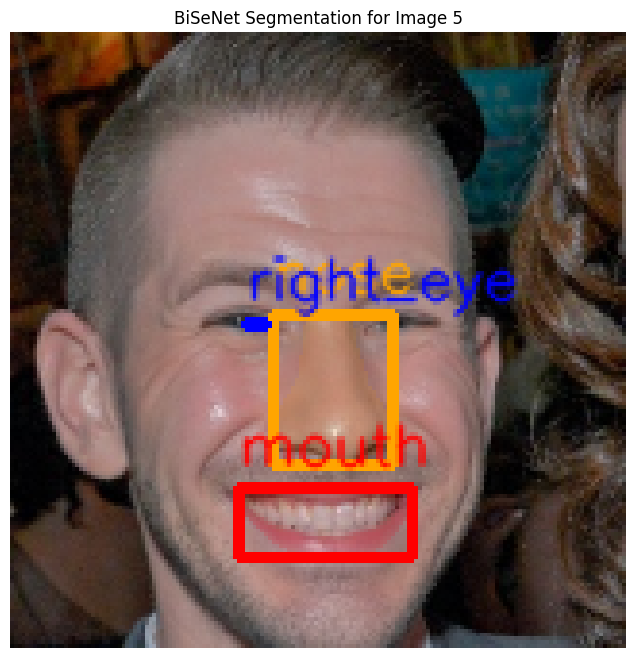

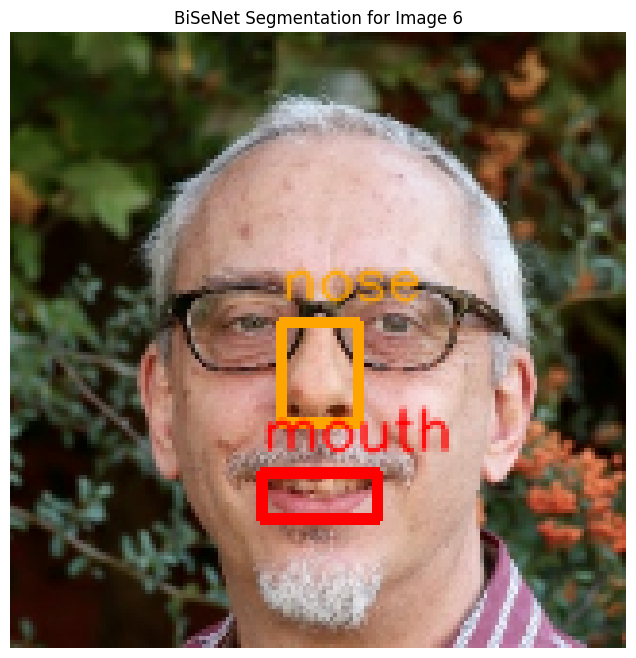

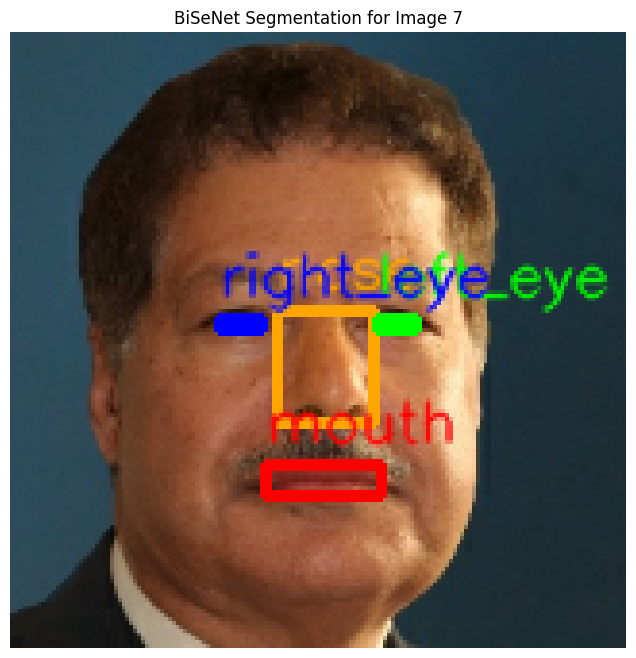

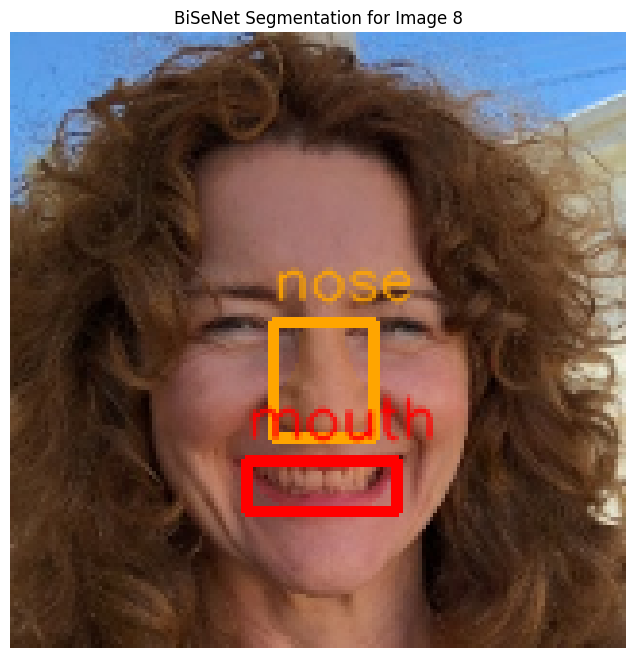

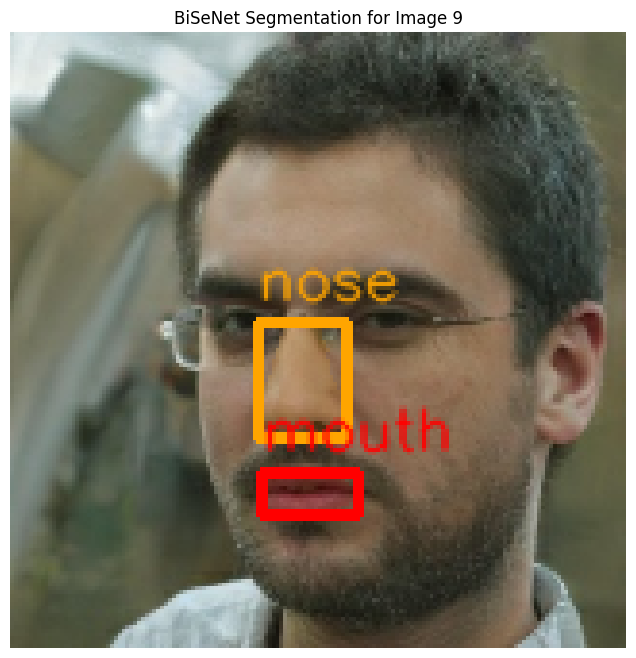

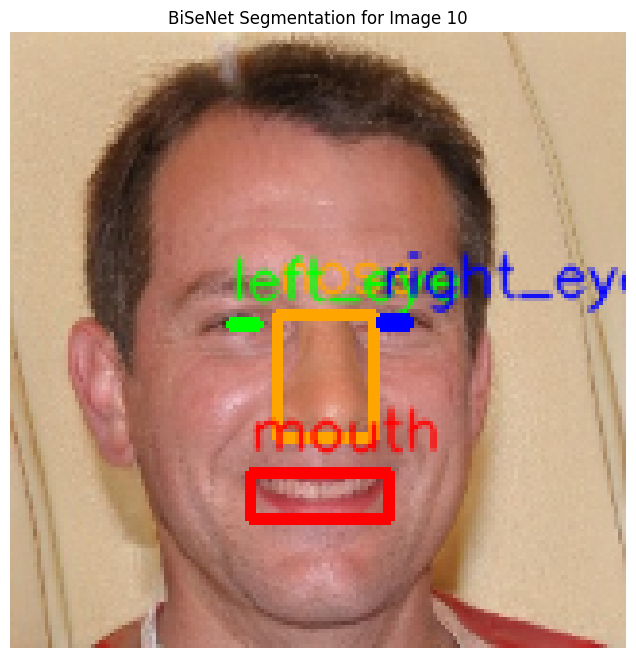

In [ ]:
for i, image in enumerate(sample_images):
    # Convert numpy image to BGR for OpenCV and then to torch tensor
    img_bgr = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2BGR)
    input_tensor, scaled_hw = preprocess(img_bgr)

    # Move tensor to the correct device
    input_tensor = input_tensor.to(DEVICE)

    # Perform inference
    with torch.no_grad():
        logits, _, _ = model(input_tensor)

    # Get the segmentation map
    orig_hw = img_bgr.shape[:2]
    seg = to_seg(logits, orig_hw, scaled_hw)

    # Define the parts to mask and box
    parts_to_highlight = {
        "nose": NOSE_IDX,
        "mouth": MOUTH_IDX,
        "left_eye": EYES_L_IDX,
        "right_eye": EYES_R_IDX
    }

    masks = {}
    boxes = {}
    for part_name, indices in parts_to_highlight.items():
        mask, box = mask_and_box(seg, indices)
        masks[part_name] = mask
        boxes[part_name] = box

    # Draw the results on the original image
    annotated_image = draw(img_bgr, boxes, masks)

    # Convert back to RGB for displaying with matplotlib
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

    # Show the annotated image
    plt.figure(figsize=(8, 8))
    plt.imshow(annotated_image_rgb)
    plt.title(f'BiSeNet Segmentation for Image {i+1}')
    plt.axis('off')
    plt.show()

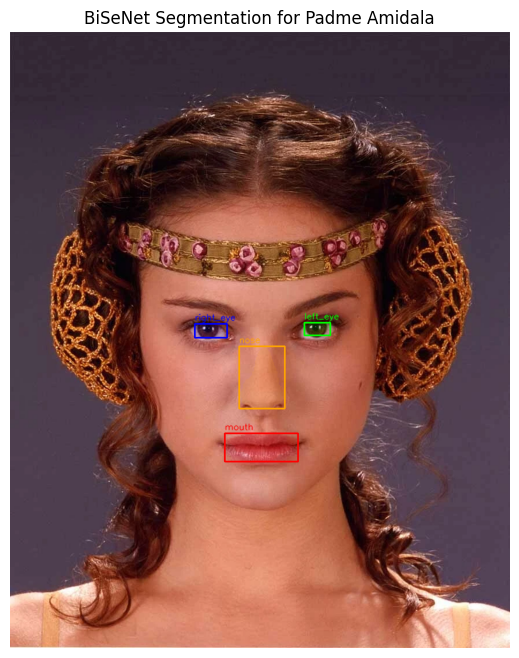

In [ ]:
# Load the image from the specified path
image_path = "/content/drive/MyDrive/Padme.webp"

if not os.path.exists(image_path):
    print(f"Error: Image not found at {image_path}")
else:
    # Read the image using OpenCV
    img_bgr = cv2.imread(image_path)

    if img_bgr is None:
        print(f"Error: Could not read the image file at {image_path}")
    else:
        # Preprocess the image
        input_tensor, scaled_hw = preprocess(img_bgr)

        # Move tensor to the correct device
        input_tensor = input_tensor.to(DEVICE)

        # Perform inference
        with torch.no_grad():
            logits, _, _ = model(input_tensor)

        # Get the segmentation map
        orig_hw = img_bgr.shape[:2]
        seg = to_seg(logits, orig_hw, scaled_hw)

        # Define the parts to mask and box (using the indices defined earlier)
        parts_to_highlight = {
            "nose": NOSE_IDX,
            "mouth": MOUTH_IDX,
            "left_eye": EYES_L_IDX,
            "right_eye": EYES_R_IDX
        }

        masks = {}
        boxes = {}
        for part_name, indices in parts_to_highlight.items():
            mask, box = mask_and_box(seg, indices)
            masks[part_name] = mask
            boxes[part_name] = box

        # Draw the results on the original image
        annotated_image = draw(img_bgr, boxes, masks)

        # Convert back to RGB for displaying with matplotlib
        annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

        # Show the annotated image
        plt.figure(figsize=(8, 8))
        plt.imshow(annotated_image_rgb)
        plt.title(f'BiSeNet Segmentation for Padme Amidala')
        plt.axis('off')
        plt.show()

### Comparing Performance of the two models

## Model Operations

Provide a mechanism (architecture) on how the model would be deployed

Provide a plan for model maintenance and a process for parameter update.

### Deployment Mechanism (Architecture)

For deploying the trained models (both the CNN and the Vision Transformer), a common and effective architecture is a **web service or API endpoint**. This allows the models to be accessed and utilized by various applications or systems without requiring them to have the full model training environment.

Here's a possible architecture:

1.  **Model Export:** The trained models (CNN and Vision Transformer) would be saved in a production-ready format (e.g., TensorFlow SavedModel for the CNN, or a serialized PyTorch model for the Vision Transformer).
2.  **Containerization:** The models, along with their dependencies (TensorFlow, PyTorch, OpenCV, MediaPipe, etc.), would be packaged into Docker containers. This ensures consistency across different deployment environments and simplifies dependency management.
3.  **Deployment Platform:** The Docker containers can be deployed on various platforms, including:
    *   **Cloud Platforms (e.g., Google Cloud Platform, AWS, Azure):** These platforms offer managed services for deploying and scaling containerized applications (e.g., Google Kubernetes Engine, Cloud Run, AWS ECS, Azure Kubernetes Service). This provides scalability, reliability, and ease of management.
    *   **On-Premises Servers:** For stricter data privacy or control requirements, the containers can be deployed on internal servers using container orchestration tools like Kubernetes or Docker Swarm.
4.  **API Gateway/Load Balancer:** To handle incoming requests and distribute traffic across multiple instances of the deployed model service, an API Gateway or Load Balancer would be used. This ensures high availability and scalability.
5.  **Inference Service:** A lightweight web framework (e.g., Flask, FastAPI for Python) within the Docker container would expose an API endpoint. This endpoint would receive image data, preprocess it, run inference using the loaded model, and return the prediction (e.g., "Real" or "Fake" with confidence score) in a structured format (e.g., JSON).
6.  **Monitoring and Logging:** Implement monitoring tools to track the performance of the deployed models (e.g., latency, error rates, resource utilization) and logging to record requests, responses, and any errors.

**Specific Considerations for each model:**

*   **CNN Model:** Given its relatively smaller size and faster inference time, it could potentially be deployed on less powerful infrastructure or even at the edge (if further optimized).
*   **Vision Transformer Model:** Due to its larger size and potentially higher computational requirements for inference, it might require more robust hardware or accelerated computing instances (e.g., GPUs) for optimal performance, especially for real-time applications.

### Model Maintenance and Parameter Update Plan

Model maintenance is crucial for ensuring the continued performance and relevance of the deployed models. This involves monitoring, retraining, and updating the models as needed.

1.  **Monitoring:**
    *   **Performance Metrics:** Continuously monitor key performance indicators (KPIs) such as accuracy, precision, recall, F1-score, and AUC on a representative sample of incoming data.
    *   **Data Drift Detection:** Implement mechanisms to detect changes in the distribution of incoming data (data drift). Significant data drift can indicate that the training data is no longer representative of the real-world data, potentially degrading model performance.
    *   **Error Analysis:** Analyze predictions where the model is uncertain or incorrect to identify patterns or specific types of images causing issues.
2.  **Retraining Strategy:**
    *   **Scheduled Retraining:** Plan for periodic retraining of the models using a refreshed dataset that includes new data, especially examples of newly generated fake faces or variations in real faces. The frequency of retraining will depend on the rate of data drift and the required performance level.
    *   **Triggered Retraining:** Implement triggers for retraining based on monitoring metrics. For example, if the accuracy drops below a certain threshold or significant data drift is detected, an automated retraining process can be initiated.
    *   **Data Annotation:** A process for acquiring and annotating new data (real and fake faces) will be necessary to support retraining.
3.  **Parameter Update Process:**
    *   **Version Control:** Use a version control system (e.g., Git) to manage different versions of the model code, training scripts, and configuration files.
    *   **Experiment Tracking:** Utilize experiment tracking tools (e.g., MLflow, Weights & Biases) to track training runs, hyperparameters, and model performance metrics.
    *   **Automated Retraining Pipeline:** Set up an automated pipeline for retraining the models. This pipeline should handle data ingestion, preprocessing, model training, evaluation, and validation.
    *   **Model Registry:** Maintain a model registry to store different versions of the trained models and their associated metadata.
    *   **Staged Rollout:** When deploying a new version of a model, consider a staged rollout strategy (e.g., canary deployments, blue/green deployments) to gradually expose the new model to production traffic and monitor its performance before fully replacing the old version. This helps mitigate risks associated with deploying new models.
    *   **Rollback Plan:** Have a clear rollback plan in place in case a new model version exhibits unexpected behavior or performance degradation in production.

By implementing these strategies, you can ensure that your AI-generated face classification models remain effective and reliable over time.